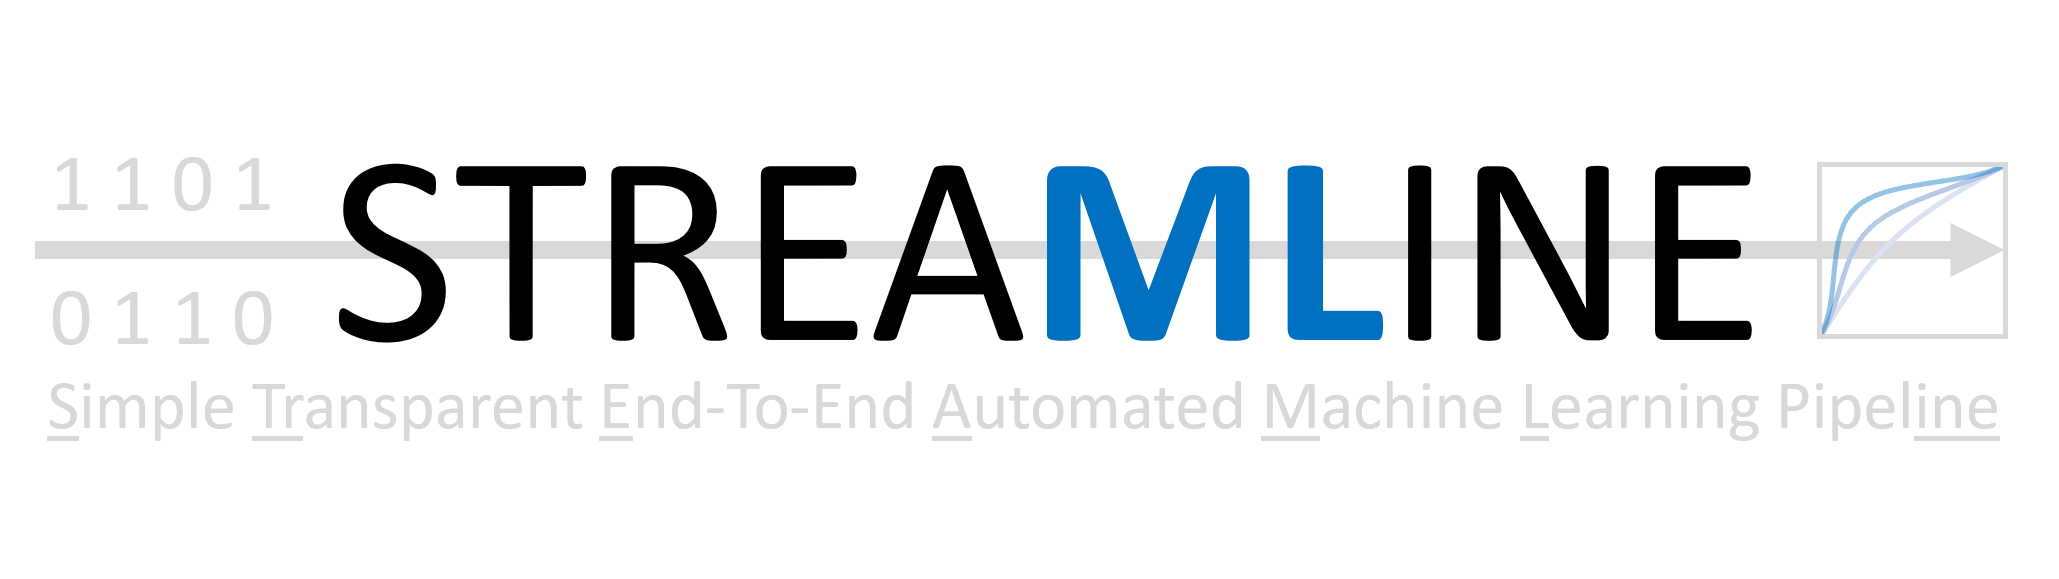

# Summary

This notebook runs all aspects of the STREAMLINE which is an automated machine learning analysis pipeline for binary classification tasks. Of note, two potentially important elements that are not automated by this pipeline include careful data cleaning and feature engineering using problem domain knowledge. Please review the README included in the associated GitHub repository for a detailed overview of how to run this pipeline. For simplicity, this notebook runs Python code outside of what is visible within it. 

This notebook is set up to run 'as-is' on a 'demo' dataset from the UCI repository (HCC dataset) using only three modeling algorithms (so that it runs in a matter of minutes). We analyze a copy of the dataset with and without covariate features to show how this pipline can be run on multiple datasets simultaneously (having the option to compare modeling on these different datasets in a later phase of the pipeline. Users will need to update pipeline run parameters below to ready the pipeline for their own needs. Suggested default run parameters suitible for most users are included, however file paths and names will need to be edited to run anything other than the 'demo' analysis. 

## Notebook Housekeeping
Set up notebook cells to display desired results. No need to edit.

In [1]:
import warnings
import sys
import os
warnings.filterwarnings('ignore')

# Jupyter Notebook Hack: This code ensures that the results of multiple commands within a given cell are all displayed, rather than just the last. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## -----------------------------------------------------------------------------------------------------------------
## (User Specified) Run Parameters of STREAMLINE
These initial notebook cells include all customizable run parameters for STREAMLINE. These settings should only be left unchanged for users wishing to test out the pipeline demo (as is) to learn how it works or to confirm efficacy before running their own data. Run parameters for each phase of the pipeline are included in separate code cells of this section of the notebook.


### Mandatory Run Parameters for Pipeline

In [2]:
demo_run = True #Leave true to run the local demo dataset (without specifying any datapaths), make False to specify a different data folder path below

#Target dataset folder path(must include one or more .txt or .csv datasets)
data_path = "C:/Users/ryanu/OneDrive/Documents/GitHub/STREAMLINE/DemoData" # (str) Demontration Data Path Folder

#Output foder path: where to save pipeline outputs (must be updated for a given user)
output_path = 'C:/Users/ryanu/Documents/Analysis/STREAMLINE_Experiments' # (str) Demonstration Ouput Path Folder

#Unique experiment name - folder created for this analysis within output folder path
experiment_name = 'hcc_demo'  # (str) Demontration Experiment Name

# Data Labels
class_label = 'Class' # (str) i.e. class outcome column label
instance_label = 'InstanceID' # (str) If data includes instance labels, given respective column name here, otherwise put 'None'

#Option to manually specify feature names to leave out of analysis, or which to treat as categorical (without using built in variable type detector)
ignore_features = [] # list of column names (given as string values) to exclude from the analysis (only insert column names if needed, otherwise leave empty)
categorical_feature_headers = [] # empty list for 'auto-detect' otherwise list feature names (given as string values) to be treated as categorical. Only impacts algorithms that can take variable type into account.

### Run Parameters for Phase 1: Exploratory Analysis

In [3]:
cv_partitions = 3  # (int, > 1) Number of training/testing data partitions to create - and resulting number of models generated using each ML algorithm
partition_method = 'S' # (str, S R or M) for stratified, random, or matched, respectively
match_label = 'None' # (str) Only applies when M selected for partition-method; indicates column label with matched instance ids' 

categorical_cutoff = 10 # (int) Bumber of unique values after which a variable is considered to be quantitative vs categorical
sig_cutoff = 0.05 # (float, 0-1) Significance cutoff used throughout pipeline
export_feature_correlations = 'True' # (str, True or False) Run and export feature correlation analysis (yields correlation heatmap)
export_univariate_plots = 'True' # (str, True or False) Export univariate analysis plots (note: univariate analysis still output by default)
topFeatures = 20 # (int) Number of top features to report in notebook for univariate analysis
random_state = 42 # (int) Sets a specific random seed for reproducible results

### Run Parameters for Phase 2: Data Preprocessing

In [4]:
scale_data = 'True' # (str, True or False) Perform data scaling?
impute_data = 'True' # (str, True or False) Perform missing value data imputation? (required for most ML algorithms if missing data is present)
overwrite_cv = 'True' # (str, True or False) Overwrites earlier cv datasets with new scaled/imputed ones
multi_impute = 'True' # (str, True or False) Applies multivariate imputation to quantitative features, otherwise uses mean imputation

### Run Parameters for Phase 3: Feature Importance Evaluation

In [5]:
do_mutual_info = 'True' # (str, True or False) Do mutual information analysis
do_multisurf = 'True' # (str, True or False) Do multiSURF analysis
use_TURF = 'False' # (str, True or False) Use TURF wrapper around MultiSURF
TURF_pct = 0.5 # (float, 0.01-0.5) Proportion of instances removed in an iteration (also dictates number of iterations)
njobs = -1 # (int) Number of cores dedicated to running algorithm; setting to -1 will use all available cores
instance_subset = 2000 # (int) Sample subset size to use with multiSURF

### Run Parameters for Phase 4: Feature Selection

In [6]:
max_features_to_keep = 2000 # (int) Maximum features to keep. 'None' if no max
filter_poor_features = 'True' # (str, True or False) Filter out the worst performing features prior to modeling
top_features = 40 # (int) Number of top features to illustrate in figures
export_scores = 'True' # (str, True or False) Export figure summarizing average feature importance scores over cv partitions

### Run Parameters for Phase 5: Modeling

In [7]:
#ML Model Algorithm Options (individual hyperparameter options can be adjusted below)
do_all = 'False'      # (str, True or False) indicates default value for whether all or none of the algorithms should be run
do_NB = 'True'        # (str, True or False, or None) Run naive bayes modeling
do_LR = 'True'        # (str, True or False, or None) Run logistic regression modeling
do_DT = 'True'        # (str, True or False, or None) Run decision tree modeling
do_RF = 'None'        # (str, True or False, or None) Run random forest modeling
do_GB = 'None'        # (str, True or False, or None) Run gradient boosting modeling
do_XGB = 'None'       # (str, True or False, or None) Run XGBoost modeling
do_LGB = 'None'       # (str, True or False, or None) Run LGBoost modeling
do_CGB = 'None'       # (str, True or False, or None) Run Catboost modeling
do_SVM = 'None'       # (str, True or False, or None) Run support vector machine modeling
do_ANN = 'None'       # (str, True or False, or None) Run artificial neural network modeling
do_KNN = 'None'       # (str, True or False, or None) Run k-neighbors classifier modeling
do_GP = 'None'        # (str, True or False, or None) Run genetic programming symbolic classifier modeling

# ML Algorithms implemented by our reserach group: Rule-based ML Algorithm Options (Computationally expensive, so can be impractical to run hyperparameter sweep)
do_eLCS = 'False'     # (str, True or False, or None) Run eLCS modeling (a basic supervised-learning learning classifier system)
do_XCS = 'False'      # (str, True or False, or None) Run XCS modeling (a supervised-learning-only implementation of the best studied learning classifier system)
do_ExSTraCS = 'None' # (str, True or False, or None) Run ExSTraCS modeling (a learning classifier system designed for biomedical data mining)

#Other Analysis Parameters
training_subsample = 0  # (int) For long running algorithms, option to subsample training set (0 for no subsample) Limit Sample Size Used to train algorithms that do not scale up well in large instance spaces (i.e. XGB,SVM,KN,ANN,and LR to a lesser degree) and depending on 'instances' settings, ExSTraCS, eLCS, and XCS)
use_uniform_FI = 'True' # (str, True or False) Overides use of any available feature importances estimate methods from models, instead using permutation_importance uniformly
primary_metric = 'balanced_accuracy' # (str) Must be an available metric identifier from (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

#Hyperparameter Sweep Options
n_trials = 200   # (int) Number of bayesian hyperparameter optimization trials using optuna
timeout = 900    # (int) Seconds until hyperparameter sweep stops running new trials (Note: it may run longer to finish last trial started)
export_hyper_sweep_plots = 'True' # (str, True or False) Export hyper parameter sweep plots from optuna

#Learning classifier system specific options (ExSTraCS, eLCS, XCS)
do_lcs_sweep = 'False' # (str, True or False) Do LCS hyperparam tuning or use below params
nu = 1                 # (int, 0-10) Fixed LCS nu param
iterations = 200000    # (int, > data sample size) Fixed LCS # learning iterations param
N = 2000               # (int) > 500) Fixed LCS rule population maximum size param
lcs_timeout = 1200     # (int) Seconds until hyperparameter sweep stops for LCS algorithms (evolutionary algorithms often require more time for a single run)

### Hyperparameter Sweep Options for ML Algorithms
Users can extend or limit the range or options for given ML algorithm hyperparameters to be tested in hyperparameter optimization. These options are hardcoded when running this pipeline from the command line, but they are available here for users to see and modify. We have sought to include a broad range of relevant configurations based on online examples and relevant research publications. Use caution when modifying values below as improper modifications will lead to pipeline errors/failure. Links to available hyperparameter options for each algorithm are included below. 

In [8]:
def hyperparameters(random_state,do_lcs_sweep,nu,iterations,N,feature_names):
    param_grid = {}
    # Naive Bayes - no hyperparameters
    
    # Logistic Regression (Note: can take longer to run in data with larger instance spaces)
    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    param_grid_LR = {'penalty': ['l2', 'l1'],'C': [1e-5, 1e5],'dual': [True, False],
                     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                     'class_weight': [None, 'balanced'],'max_iter': [10, 1000],
                     'random_state':[random_state]}
    
    # Decision Tree
    # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decision%20tree%20classifier#sklearn.tree.DecisionTreeClassifier
    param_grid_DT = {'criterion': ['gini', 'entropy'],'splitter': ['best', 'random'],'max_depth': [1, 30],
                     'min_samples_split': [2, 50],'min_samples_leaf': [1, 50],'max_features': [None, 'auto', 'log2'],
                     'class_weight': [None, 'balanced'],
                     'random_state':[random_state]}
    
    # Random Forest
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier
    param_grid_RF = {'n_estimators': [10, 1000],'criterion': ['gini', 'entropy'],'max_depth': [1, 30],
                     'min_samples_split': [2, 50],'min_samples_leaf': [1, 50],'max_features': [None, 'auto', 'log2'],
                     'bootstrap': [True],'oob_score': [False, True],'class_weight': [None, 'balanced'],
                     'random_state':[random_state]}
    
    # Gradient Boosting Trees
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=gradient%20boosting#sklearn.ensemble.GradientBoostingClassifier
    param_grid_GB = {'n_estimators': [10, 1000],'loss': ['deviance', 'exponential'], 'learning_rate': [.0001, 0.3], 
                     'min_samples_leaf': [1, 50],'min_samples_split': [2, 50], 'max_depth': [1, 30],
                     'random_state':[random_state]}
    
    # XG Boost (Note: Not great for large instance spaces (limited completion) and class weight balance is included as option internally
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    param_grid_XGB = {'booster': ['gbtree'],'objective': ['binary:logistic'],'verbosity': [0],'reg_lambda': [1e-8, 1.0],
                      'alpha': [1e-8, 1.0],'eta': [1e-8, 1.0],'gamma': [1e-8, 1.0],'max_depth': [1, 30],
                      'grow_policy': ['depthwise', 'lossguide'],'n_estimators': [10, 1000],'min_samples_split': [2, 50],
                      'min_samples_leaf': [1, 50],'subsample': [0.5, 1.0],'min_child_weight': [0.1, 10],
                      'colsample_bytree': [0.1, 1.0],'nthread':[1],'random_state':[random_state]}

    # LG Boost (Note: class weight balance is included as option internally (still takes a while on large instance spaces))
    # https://lightgbm.readthedocs.io/en/latest/Parameters.html
    param_grid_LGB = {'objective': ['binary'],'metric': ['binary_logloss'],'verbosity': [-1],'boosting_type': ['gbdt'],
                      'num_leaves': [2, 256],'max_depth': [1, 30],'lambda_l1': [1e-8, 10.0],'lambda_l2': [1e-8, 10.0],
                      'feature_fraction': [0.4, 1.0],'bagging_fraction': [0.4, 1.0],'bagging_freq': [1, 7],
                      'min_child_samples': [5, 100],'n_estimators': [10, 1000],'num_threads':[1],'random_state':[random_state]}

    # CatBoost - (Note this is newly added, and further optimization to this configuration is possible)
    # https://catboost.ai/en/docs/references/training-parameters/
    param_grid_CGB = {'learning_rate':[.0001, 0.3],'iterations':[10,500],'depth':[1,10],'l2_leaf_reg': [1,9],
                      'loss_function': ['Logloss'], 'random_seed': [random_state]}
    
    # Support Vector Machine (Note: Very slow in large instance spaces)
    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
    param_grid_SVM = {'kernel': ['linear', 'poly', 'rbf'],'C': [0.1, 1000],'gamma': ['scale'],'degree': [1, 6],
                      'probability': [True],'class_weight': [None, 'balanced'],'random_state':[random_state]}
    
    # Artificial Neural Network (Note: Slow in large instances spaces, and poor performer in small instance spaces)
    # https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html?highlight=artificial%20neural%20network
    param_grid_ANN = {'n_layers': [1, 3],'layer_size': [1, 100],'activation': ['identity', 'logistic', 'tanh', 'relu'],
                      'learning_rate': ['constant', 'invscaling', 'adaptive'],'momentum': [.1, .9],
                      'solver': ['sgd', 'adam'],'batch_size': ['auto'],'alpha': [0.0001, 0.05],'max_iter': [200],
                      'random_state':[random_state]}
    
    # K-Nearest Neighbor Classifier (Note: Runs slowly in data with large instance space)
    # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier
    param_grid_KNN = {'n_neighbors': [1, 100], 'weights': ['uniform', 'distance'], 'p': [1, 5],
                     'metric': ['euclidean', 'minkowski']}
    
    # Genetic Programming Symbolic Classifier
    # https://gplearn.readthedocs.io/en/stable/reference.html
    param_grid_GP = {'population_size': [100, 1000], 'generations': [10, 500], 'tournament_size': [3, 50],'init_method': ['grow', 'full','half and half'],
                     'function_set': [['add', 'sub', 'mul', 'div'], ['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min'], ['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min','sin','cos','tan']],
                     'parsimony_coefficient': [0.001,0.01],'feature_names': [feature_names], 'low_memory': [True],'random_state': [random_state]}

    # Learning Classifier Systems (i.e. eLCS, XCS, and ExSTraCS)
    # https://github.com/UrbsLab/scikit-eLCS
    # https://github.com/UrbsLab/scikit-XCS
    # https://github.com/UrbsLab/scikit-ExSTraCS
    
    if eval(do_lcs_sweep):
        # eLCS
        param_grid_eLCS = {'learning_iterations': [100000,200000,500000],'N': [1000,2000,5000],'nu': [1,10],
                           'random_state':[random_state]}
        # XCS
        param_grid_XCS = {'learning_iterations': [100000,200000,500000],'N': [1000,2000,5000],'nu': [1,10],
                          'random_state':[random_state]}
        # ExSTraCS
        param_grid_ExSTraCS = {'learning_iterations': [100000,200000,500000],'N': [1000,2000,5000],'nu': [1,10],
                               'random_state':[random_state],'rule_compaction':[None]}
    else:
        # eLCS
        param_grid_eLCS = {'learning_iterations': [iterations], 'N': [N], 'nu': [nu], 'random_state': [random_state]}
        # XCS
        param_grid_XCS = {'learning_iterations': [iterations], 'N': [N], 'nu': [nu], 'random_state': [random_state]}
        # ExSTraCS
        param_grid_ExSTraCS = {'learning_iterations': [iterations], 'N': [N], 'nu': [nu], 'random_state': [random_state], 
                               'rule_compaction': ['QRF']} # 'None','QRF' - which is quick rule filter
        
    #Leave code below as is...
    param_grid['Naive Bayes'] = {}
    param_grid['Logistic Regression'] = param_grid_LR
    param_grid['Decision Tree'] = param_grid_DT
    param_grid['Random Forest'] = param_grid_RF
    param_grid['Gradient Boosting'] = param_grid_GB
    param_grid['Extreme Gradient Boosting'] = param_grid_XGB
    param_grid['Light Gradient Boosting'] = param_grid_LGB
    param_grid['Category Gradient Boosting'] = param_grid_CGB
    param_grid['Support Vector Machine'] = param_grid_SVM
    param_grid['Artificial Neural Network'] = param_grid_ANN
    param_grid['K-Nearest Neightbors'] = param_grid_KNN
    param_grid['Genetic Programming'] = param_grid_GP
    param_grid['eLCS'] = param_grid_eLCS
    param_grid['XCS'] = param_grid_XCS
    param_grid['ExSTraCS'] = param_grid_ExSTraCS
    return param_grid

### Run Parameters for Phase 6:  Statistics Summary and Figure Generation

In [9]:
plot_ROC = 'True'    # (str, True or False) Plot ROC curves individually for each algorithm including all CV results and averages
plot_PRC = 'True'    # (str, True or False) Plot PRC curves individually for each algorithm including all CV results and averages
plot_FI_box = 'True' # (str, True or False) Plot box plot summaries comparing algorithms for each metric
plot_metric_boxplots = 'True' # (str, True or False) Plot feature importance boxplots for each algorithm
metric_weight = 'roc_auc'#'balanced_accuracy' # (str, balanced_accuracy or roc_auc) ML model metric used as weight in composite FI plots (only supports balanced_accuracy or roc_auc as options) Recommend setting the same as primary_metric if possible.
top_model_features = 40  # (int) Number of top features in model to illustrate in figures

### Run Parameters for Phase 10:  Apply Models to Replication Dataset
An optional phase to apply all trained models from previous phases to a separate 'replication' dataset which will be used to evaluate models across all algorithms and CV splits. In this demo, we didn't have a separate replication dataset to use for the UCI HCC dataset evaluated. Thus here we use a copy of the original HCC dataset as a 'pretend' replication dataset to demonstrate functionality. The replication data folder can include 1 or more datasets that can be evaluated as separate replication data. The user also needs to 

In [10]:
applyToReplication = True # (Boolean, True or False) Leave false unless you have a replication dataset handy to further evaluate/compare all models in uniform manner
rep_data_path = "C:/Users/ryanu/OneDrive/Documents/GitHub/STREAMLINE/DemoRepData" # (txt) Name of folder with replication Dataset(s)
data_path_for_rep = "C:/Users/ryanu/OneDrive/Documents/GitHub/STREAMLINE/DemoData/hcc-data_example.csv" # (txt) Path and name of dataset used to generate the models we want to apply (not the replication dataset)

### Run Parameters for Phase 11:  File Cleanup
An optional phase to delete all unnecessary/temporary files generated by the pipeline.

In [11]:
del_time = 'True'  # (str, True or False) Delete individual run-time files (but save summary)
del_oldCV = 'True' # (str, True or False) Delete any of the older versions of CV training and testing datasets not overwritten (preserves final training and testing datasets)

## -----------------------------------------------------------------------------------------------------------------
## Phase 1: Exploratory Analysis

### Identify Working Directory

In [12]:
wd_path = os.getcwd() #Working directory path automatically detected
wd_path = wd_path.replace('\\','/')
sys.path.insert(1, wd_path+'/streamline')

### Import Python Packages

In [13]:
import glob
import time
import csv
import pandas as pd
import numpy as np
import random
import pickle
import ExploratoryAnalysisMain
import ExploratoryAnalysisJob

### Demo Setup
Bypasses whatever user may have entered into 'data_path' variable to ensure proper loading of local 'demo' dataset.

In [14]:
if demo_run:
    data_path = wd_path+'/DemoData'
print("Data Folder Path: "+data_path)
jupyterRun = 'True' #Leave True or pipeline will not display text or figures

Data Folder Path: C:/Users/UrbanowiczR/Documents/GitHub/STREAMLINE/DemoData


### Run Exploratory Analysis

In [15]:
ExploratoryAnalysisMain.makeDirTree(data_path,output_path,experiment_name,jupyterRun)

---------------------------------------------------------------------------------
C:/Users/UrbanowiczR/Documents/GitHub/STREAMLINE/DemoData/hcc-data_example.csv
Loading Dataset: hcc-data_example
Cleaning Dataset...
Identifying Feature Types...
Running Basic Exploratory Analysis...


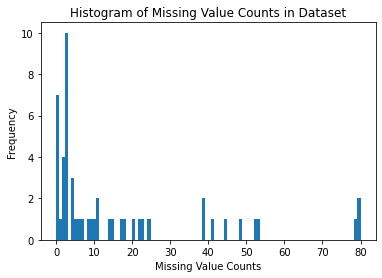

Data Counts: ----------------
Instance Count = 165
Feature Count = 49
    Categorical  = 27
    Quantitative = 22
Missing Count = 826
    Missing Percent = 0.10216450216450217
Class Counts: ----------------
0    102
1     63
Name: Class, dtype: int64


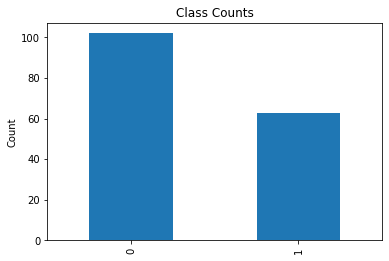

Generating Feature Correlation Heatmap...


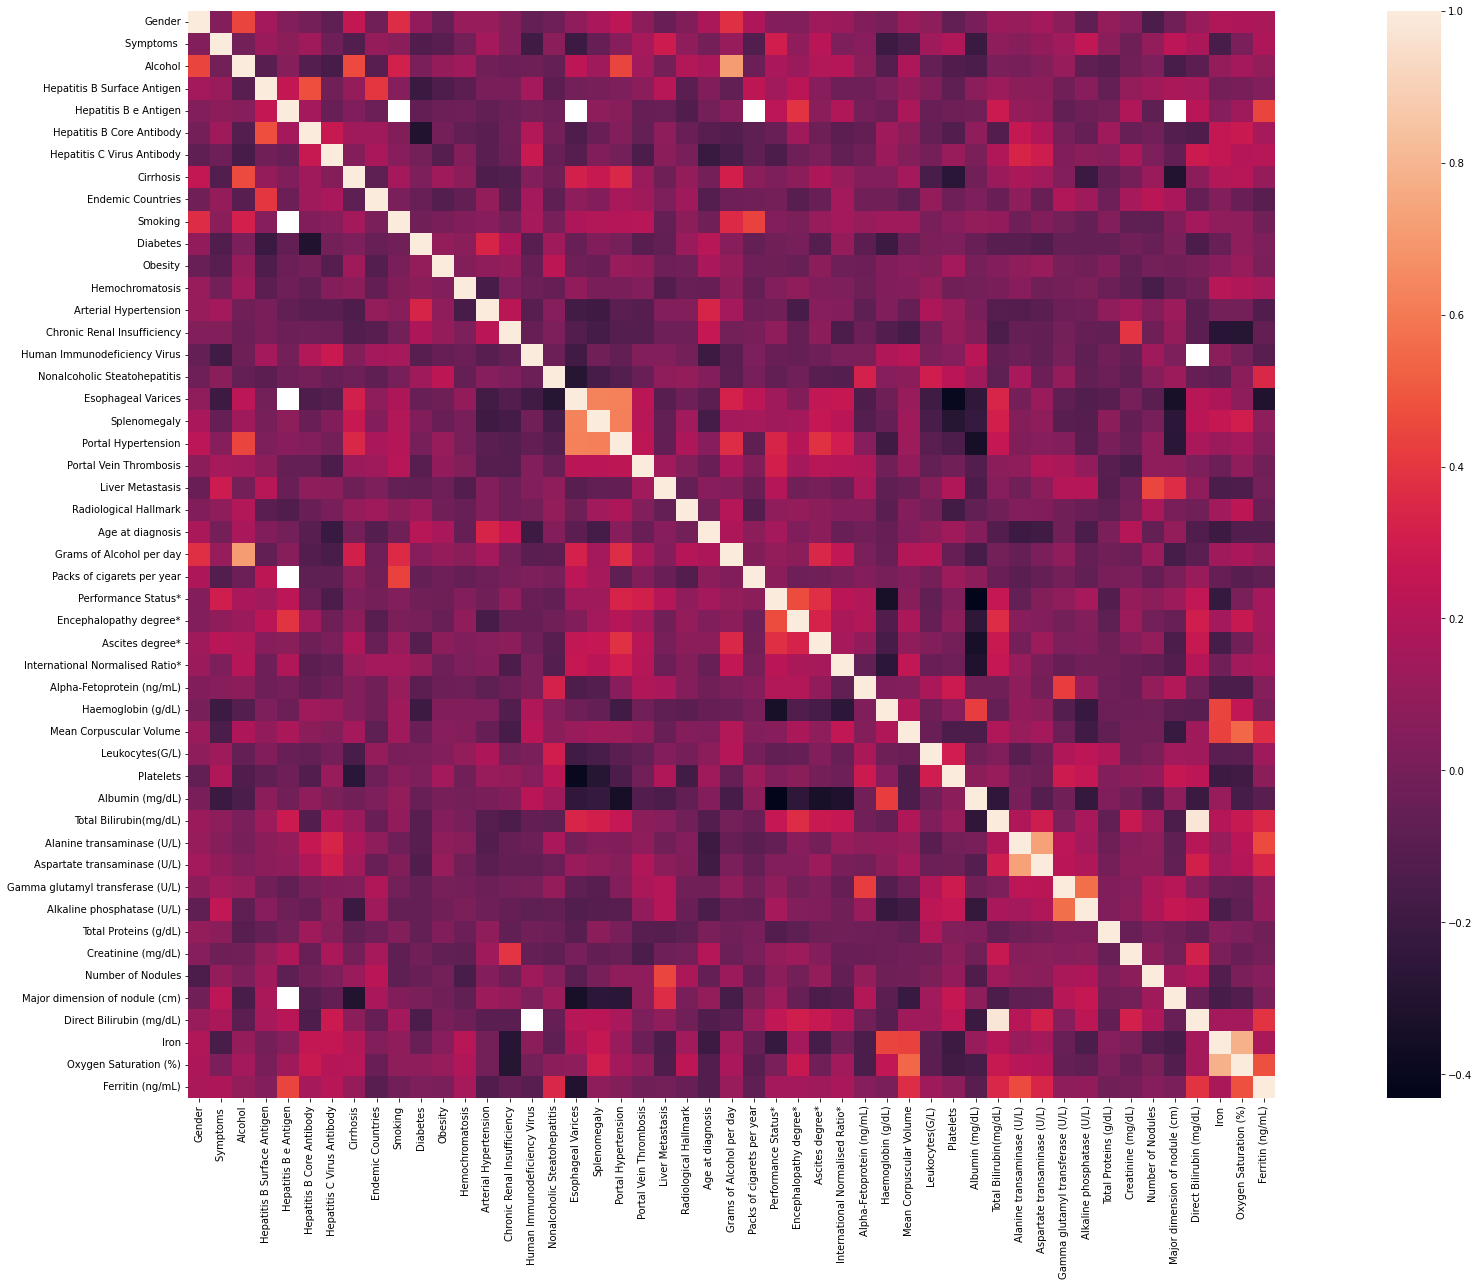

Running Univariate Analyses...
Generating Univariate Analysis Plots...
Generating and Saving CV Datasets...
hcc-data_example phase 1 complete
---------------------------------------------------------------------------------
C:/Users/UrbanowiczR/Documents/GitHub/STREAMLINE/DemoData/hcc-data_example_no_covariates.csv
Loading Dataset: hcc-data_example_no_covariates
Cleaning Dataset...
Identifying Feature Types...
Running Basic Exploratory Analysis...


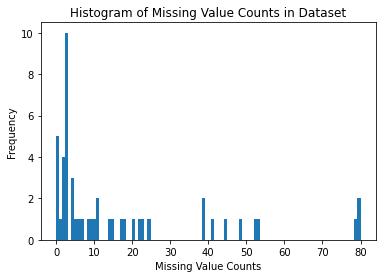

Data Counts: ----------------
Instance Count = 165
Feature Count = 47
    Categorical  = 26
    Quantitative = 21
Missing Count = 826
    Missing Percent = 0.10651192778852353
Class Counts: ----------------
0    102
1     63
Name: Class, dtype: int64


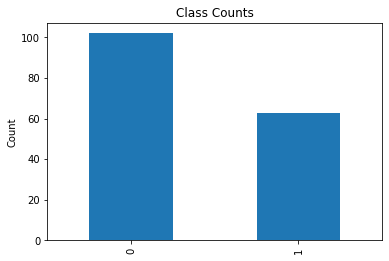

Generating Feature Correlation Heatmap...


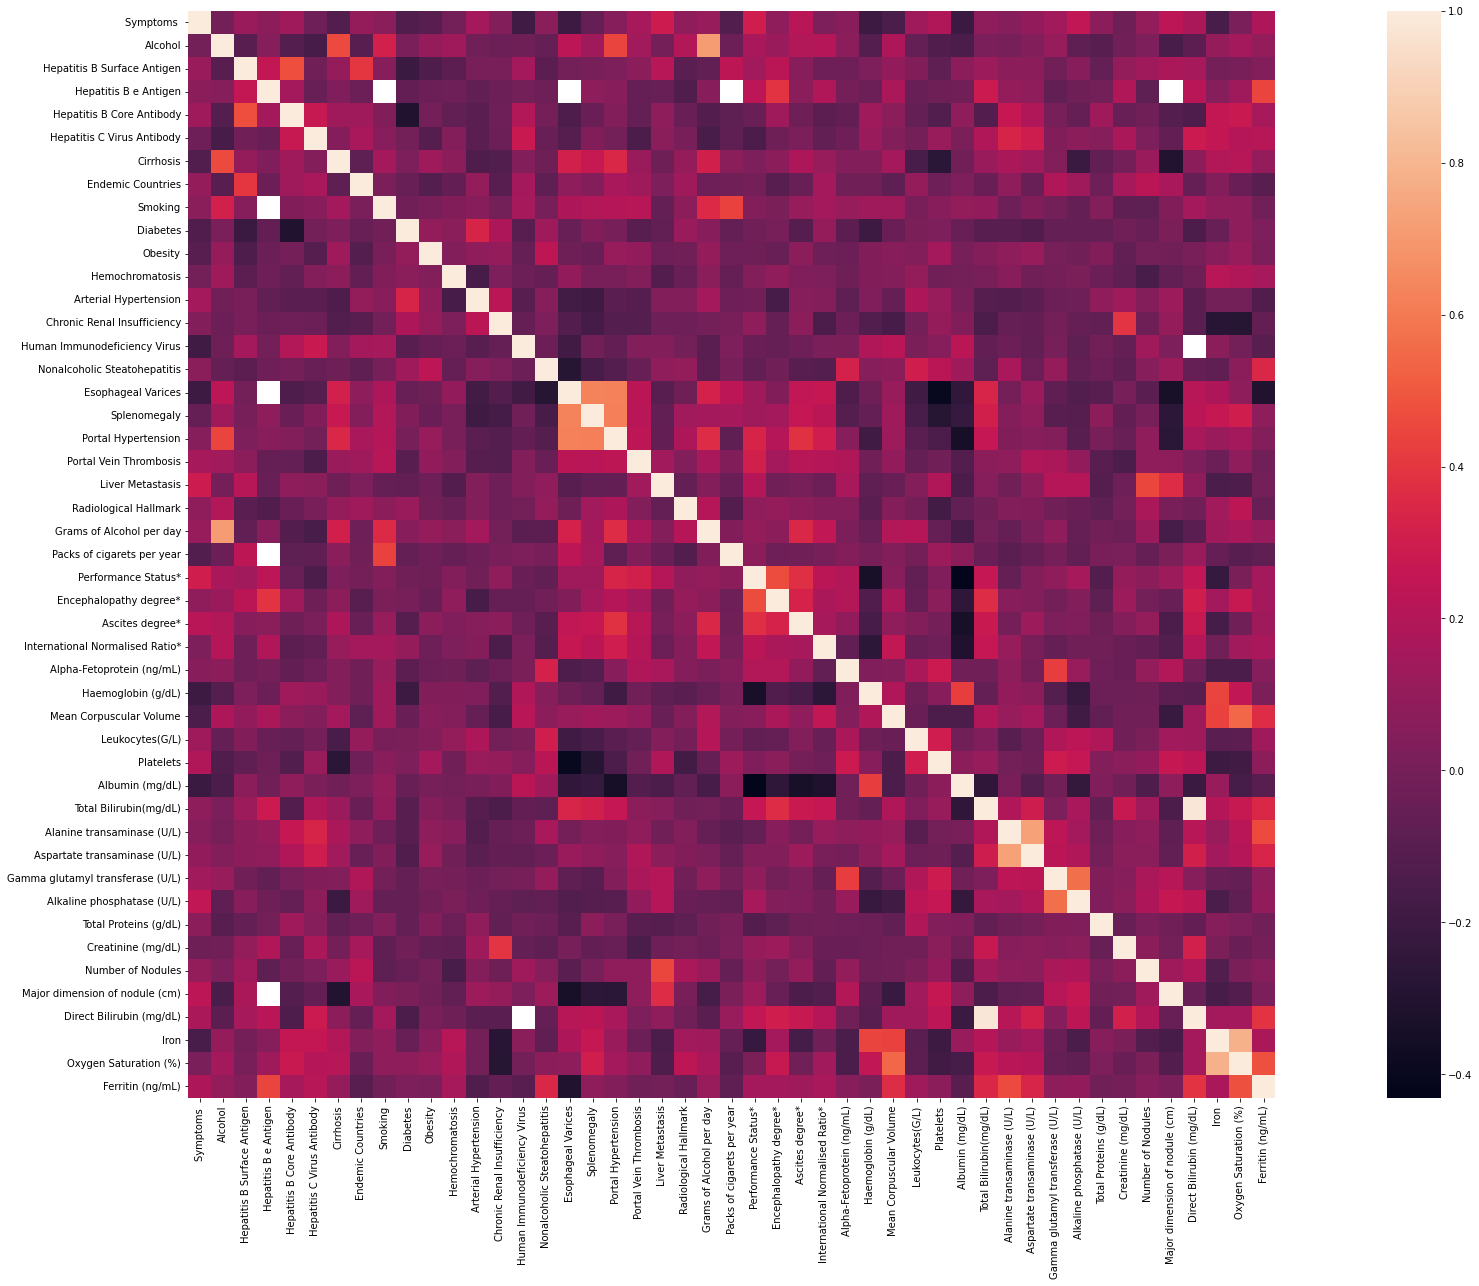

Running Univariate Analyses...
Generating Univariate Analysis Plots...
Generating and Saving CV Datasets...
hcc-data_example_no_covariates phase 1 complete


In [16]:
#Determine file extension of datasets in target folder:
file_count = 0
unique_datanames = []
for dataset_path in glob.glob(data_path+'/*'):
    dataset_path = str(dataset_path).replace('\\','/')
    print('---------------------------------------------------------------------------------')
    print(dataset_path)
    file_extension = dataset_path.split('/')[-1].split('.')[-1]
    data_name = dataset_path.split('/')[-1].split('.')[0] #Save unique dataset names so that analysis is run only once if there is both a .txt and .csv version of dataset with same name.
    if file_extension == 'txt' or file_extension == 'csv':
        if data_name not in unique_datanames:
            unique_datanames.append(data_name)
            ExploratoryAnalysisJob.runExplore(dataset_path,output_path+'/'+experiment_name,cv_partitions,partition_method,categorical_cutoff,export_feature_correlations,export_univariate_plots,class_label,instance_label,match_label,random_state,ignore_features,categorical_feature_headers,sig_cutoff,jupyterRun)
            file_count += 1

if file_count == 0: #Check that there was at least 1 dataset
    raise Exception("There must be at least one .txt or .csv dataset in data_path directory")

#Create metadata dictionary object to keep track of pipeline run paramaters throughout phases
metadata = {}
metadata['Data Path'] = data_path
metadata['Output Path'] = output_path
metadata['Experiment Name'] = experiment_name
metadata['Class Label'] = class_label
metadata['Instance Label'] = instance_label
metadata['Ignored Features'] = ignore_features
metadata['Specified Categorical Features'] = categorical_feature_headers
metadata['CV Partitions'] = cv_partitions
metadata['Partition Method'] = partition_method
metadata['Match Label'] = match_label
metadata['Categorical Cutoff'] = categorical_cutoff
metadata['Statistical Significance Cutoff'] = sig_cutoff
metadata['Export Feature Correlations'] = export_feature_correlations
metadata['Export Univariate Plots'] = export_univariate_plots
metadata['Random Seed'] = random_state
metadata['Run From Jupyter Notebook'] = jupyterRun
#Pickle the metadata for future use
pickle_out = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'wb')
pickle.dump(metadata,pickle_out)
pickle_out.close()

## -----------------------------------------------------------------------------------------------------------------
## Phase 2: Data Preprocessing

### Import Additional Python Packages

In [17]:
import DataPreprocessingJob

### Run Data Preprocessing

In [18]:
dataset_paths = os.listdir(output_path+"/"+experiment_name)
dataset_paths.remove('metadata.pickle')
for dataset_directory_path in dataset_paths:
    full_path = output_path+"/"+experiment_name+"/"+dataset_directory_path
    for cv_train_path in glob.glob(full_path+"/CVDatasets/*Train.csv"):
        cv_train_path = str(cv_train_path).replace('\\','/')
        cv_test_path = cv_train_path.replace("Train.csv","Test.csv")
        DataPreprocessingJob.job(cv_train_path,cv_test_path,output_path+'/'+experiment_name,scale_data,impute_data,overwrite_cv,categorical_cutoff,class_label,instance_label,random_state,multi_impute,jupyterRun)

#Unpickle metadata from previous phase
file = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'rb')
metadata = pickle.load(file) 
file.close()
    
#Update metadata
metadata['Use Data Scaling'] = scale_data
metadata['Use Data Imputation'] = impute_data
metadata['Use Multivariate Imputation'] = multi_impute
#Pickle the metadata for future use
pickle_out = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'wb')
pickle.dump(metadata,pickle_out)
pickle_out.close()

Preparing Train and Test for: hcc-data_example_CV_0
Imputing Missing Values...
Scaling Data Values...
Saving Processed Train and Test Data...
hcc-data_example phase 2 complete
Preparing Train and Test for: hcc-data_example_CV_1
Imputing Missing Values...
Scaling Data Values...
Saving Processed Train and Test Data...
hcc-data_example phase 2 complete
Preparing Train and Test for: hcc-data_example_CV_2
Imputing Missing Values...
Scaling Data Values...
Saving Processed Train and Test Data...
hcc-data_example phase 2 complete
Preparing Train and Test for: hcc-data_example_no_covariates_CV_0
Imputing Missing Values...
Scaling Data Values...
Saving Processed Train and Test Data...
hcc-data_example_no_covariates phase 2 complete
Preparing Train and Test for: hcc-data_example_no_covariates_CV_1
Imputing Missing Values...
Scaling Data Values...
Saving Processed Train and Test Data...
hcc-data_example_no_covariates phase 2 complete
Preparing Train and Test for: hcc-data_example_no_covariates_CV_

## -----------------------------------------------------------------------------------------------------------------
## Phase 3: Feature Importance Evaluation

### Import Additional Python Packages

In [19]:
import FeatureImportanceJob

### Run Feature Importance Evaluation

In [20]:
dataset_paths = os.listdir(output_path+"/"+experiment_name)
removeList = removeList = ['metadata.pickle','metadata.csv','algInfo.pickle','jobsCompleted','logs','jobs','DatasetComparisons','UsefulNotebooks',experiment_name+'_ML_Pipeline_Report.pdf']
for text in removeList:
    if text in dataset_paths:
        dataset_paths.remove(text)

for dataset_directory_path in dataset_paths:
    full_path = output_path+"/"+experiment_name+"/"+dataset_directory_path
    experiment_path = output_path+'/'+experiment_name

    if eval(do_mutual_info) or eval(do_multisurf):
        if not os.path.exists(full_path+"/feature_selection"):
            os.mkdir(full_path+"/feature_selection")
            
    if eval(do_mutual_info):
        if not os.path.exists(full_path+"/feature_selection/mutualinformation"):
            os.mkdir(full_path+"/feature_selection/mutualinformation")
        for cv_train_path in glob.glob(full_path+"/CVDatasets/*_CV_*Train.csv"):
            cv_train_path = str(cv_train_path).replace('\\','/')
            FeatureImportanceJob.job(cv_train_path,experiment_path,random_state,class_label,instance_label,instance_subset,'mi',njobs,use_TURF,TURF_pct,jupyterRun)

    if eval(do_multisurf):
        if not os.path.exists(full_path+"/feature_selection/multisurf"):
            os.mkdir(full_path+"/feature_selection/multisurf")
        for cv_train_path in glob.glob(full_path+"/CVDatasets/*_CV_*Train.csv"):
            cv_train_path = str(cv_train_path).replace('\\','/')
            FeatureImportanceJob.job(cv_train_path,experiment_path,random_state,class_label,instance_label,instance_subset,'ms',njobs,use_TURF,TURF_pct,jupyterRun)

#Unpickle metadata from previous phase
file = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'rb')
metadata = pickle.load(file) 
file.close()

#Update metadata
metadata['Use Mutual Information'] = do_mutual_info
metadata['Use MultiSURF'] = do_multisurf
metadata['Use TURF'] = use_TURF
metadata['TURF Cutoff'] = TURF_pct
metadata['MultiSURF Instance Subset'] = instance_subset
#Pickle the metadata for future use
pickle_out = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'wb')
pickle.dump(metadata,pickle_out)
pickle_out.close()

Prepared Train and Test for: hcc-data_example_CV_0
Running Mutual Information...
Sort and pickle feature importance scores...
hcc-data_example CV0 phase 3 mutualinformation evaluation complete
Prepared Train and Test for: hcc-data_example_CV_1
Running Mutual Information...
Sort and pickle feature importance scores...
hcc-data_example CV1 phase 3 mutualinformation evaluation complete
Prepared Train and Test for: hcc-data_example_CV_2
Running Mutual Information...
Sort and pickle feature importance scores...
hcc-data_example CV2 phase 3 mutualinformation evaluation complete
Prepared Train and Test for: hcc-data_example_CV_0
Running MultiSURF...
Sort and pickle feature importance scores...
hcc-data_example CV0 phase 3 multisurf evaluation complete
Prepared Train and Test for: hcc-data_example_CV_1
Running MultiSURF...
Sort and pickle feature importance scores...
hcc-data_example CV1 phase 3 multisurf evaluation complete
Prepared Train and Test for: hcc-data_example_CV_2
Running MultiSURF.

## -----------------------------------------------------------------------------------------------------------------
## Phase 4: Feature Selection

### Import Additional Python Packages

In [21]:
import FeatureSelectionJob

### Run Feature Selection

Plotting Feature Importance Scores...


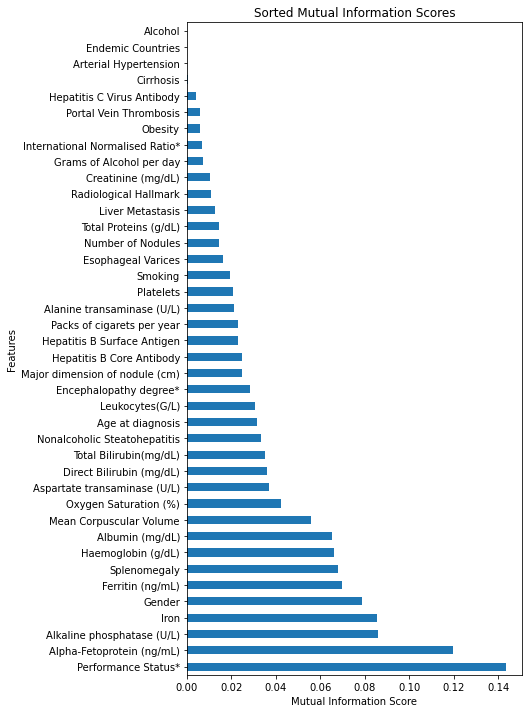

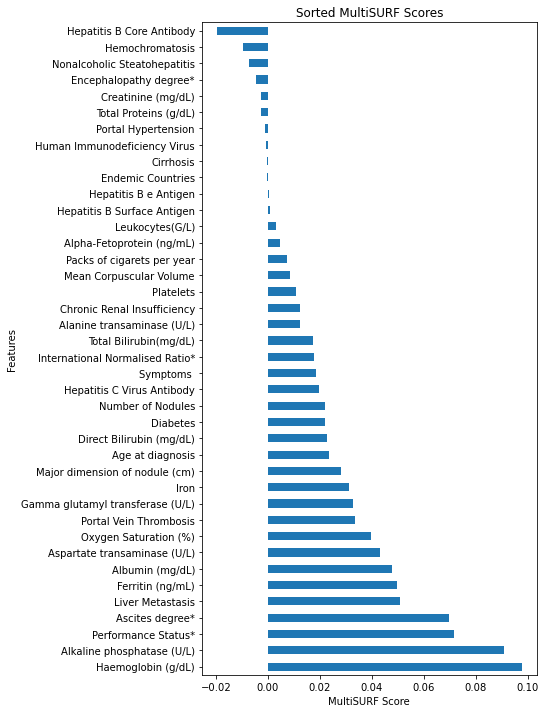

Applying collective feature selection...
hcc-data_example phase 4 complete
Plotting Feature Importance Scores...


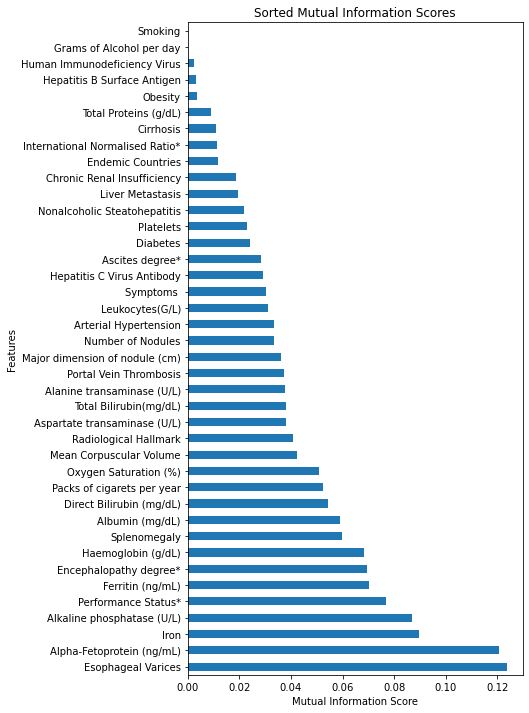

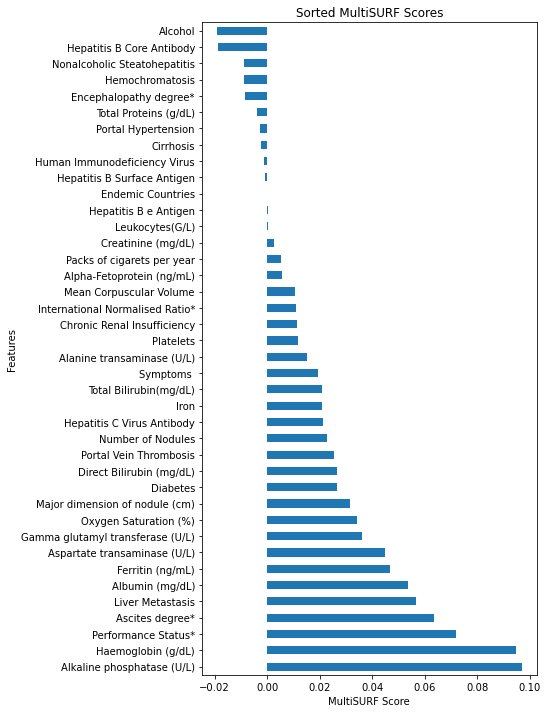

Applying collective feature selection...
hcc-data_example_no_covariates phase 4 complete


In [22]:
dataset_paths = os.listdir(output_path + "/" + experiment_name)
removeList = removeList = ['metadata.pickle','metadata.csv','algInfo.pickle','jobsCompleted','logs','jobs','DatasetComparisons','UsefulNotebooks',experiment_name+'_ML_Pipeline_Report.pdf']
for text in removeList:
    if text in dataset_paths:
        dataset_paths.remove(text)

for dataset_directory_path in dataset_paths:
    full_path = output_path + "/" + experiment_name + "/" + dataset_directory_path
    FeatureSelectionJob.job(full_path,do_mutual_info,do_multisurf,max_features_to_keep,filter_poor_features,top_features,export_scores,class_label,instance_label,cv_partitions,overwrite_cv,jupyterRun)

#Unpickle metadata from previous phase
file = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'rb')
metadata = pickle.load(file)
file.close()

#Update metadata
metadata['Max Features to Keep'] = max_features_to_keep
metadata['Filter Poor Features'] = filter_poor_features
metadata['Top Features to Display'] = top_features
metadata['Export Feature Importance Plot'] = export_scores
metadata['Overwrite CV Datasets'] = overwrite_cv
#Pickle the metadata for future use
pickle_out = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'wb')
pickle.dump(metadata,pickle_out)
pickle_out.close()

## -----------------------------------------------------------------------------------------------------------------
## Phase 5: ML Modeling

### Phase 5 Import Additional Python Packages

In [23]:
import ModelJob

In [24]:
#Create ML modeling algorithm information dictionary, given as ['algorithm used (set to true initially by default)','algorithm abreviation', 'color used for algorithm on figures']
### Note that other named colors used by matplotlib can be found here: https://matplotlib.org/3.5.0/_images/sphx_glr_named_colors_003.png
### Make sure new ML algorithm abbreviations and color designations are unique
algInfo = {}
algInfo['Naive Bayes'] = [True,'NB','silver']
algInfo['Logistic Regression'] = [True,'LR','dimgrey']
algInfo['Decision Tree'] = [True,'DT','yellow']
algInfo['Random Forest'] = [True,'RF','blue']
algInfo['Gradient Boosting'] = [True,'GB','cornflowerblue']
algInfo['Extreme Gradient Boosting'] = [True,'XGB','cyan']
algInfo['Light Gradient Boosting'] = [True,'LGB','pink']
algInfo['Category Gradient Boosting'] = [True,'CGB','magenta']
algInfo['Support Vector Machine'] = [True,'SVM','orange']
algInfo['Artificial Neural Network'] = [True,'ANN','red']
algInfo['K-Nearest Neightbors'] = [True,'KNN','chocolate']
algInfo['Genetic Programming'] = [True,'GP','purple']
algInfo['eLCS'] = [True,'eLCS','green']
algInfo['XCS'] = [True,'XCS','olive']
algInfo['ExSTraCS'] = [True,'ExSTraCS','lawngreen']
### Add new algorithms here...

#Set up ML algorithm True/False use
if not eval(do_all): #If do all algorithms is false
    for key in algInfo:
        algInfo[key][0] = False #Set algorithm use to False

#Set algorithm use truth for each algorithm specified by user (i.e. if user specified True/False for a specific algorithm)
if not do_NB == 'None':
    algInfo['Naive Bayes'][0] = eval(do_NB)
if not do_LR == 'None':
    algInfo['Logistic Regression'][0] = eval(do_LR)
if not do_DT == 'None':
    algInfo['Decision Tree'][0] = eval(do_DT)
if not do_RF == 'None':
    algInfo['Random Forest'][0] = eval(do_RF)
if not do_GB == 'None':
    algInfo['Gradient Boosting'][0] = eval(do_GB)
if not do_XGB == 'None':
    algInfo['Extreme Gradient Boosting'][0] = eval(do_XGB)
if not do_LGB == 'None':
    algInfo['Light Gradient Boosting'][0] = eval(do_LGB)
if not do_CGB == 'None':
    algInfo['Category Gradient Boosting'][0] = eval(do_CGB)
if not do_SVM == 'None':
    algInfo['Support Vector Machine'][0] = eval(do_SVM)
if not do_ANN == 'None':
    algInfo['Artificial Neural Network'][0] = eval(do_ANN)
if not do_KNN == 'None':
    algInfo['K-Nearest Neightbors'][0] = eval(do_KNN)
if not do_GP == 'None':
    algInfo['Genetic Programming'][0] = eval(do_GP)
if not do_eLCS == 'None':
    algInfo['eLCS'][0] = eval(do_eLCS)
if not do_XCS == 'None':
    algInfo['XCS'][0] = eval(do_XCS)
if not do_ExSTraCS == 'None':
    algInfo['ExSTraCS'][0] = eval(do_ExSTraCS)
### Add new algorithms here...

#Pickle the algorithm information dictionary for future use
pickle_out = open(output_path+'/'+experiment_name+'/'+"algInfo.pickle", 'wb')
pickle.dump(algInfo,pickle_out)
pickle_out.close()

#Make list of algorithms to be run (full names)
algorithms = []
for key in algInfo:
    if algInfo[key][0]: #Algorithm is true
        algorithms.append(key)

### Run ML Modeling

In [25]:
dataset_paths = os.listdir(output_path + "/" + experiment_name)
removeList = removeList = ['metadata.pickle','metadata.csv','algInfo.pickle','jobsCompleted','logs','jobs','DatasetComparisons','UsefulNotebooks',experiment_name+'_ML_Pipeline_Report.pdf']
for text in removeList:
    if text in dataset_paths:
        dataset_paths.remove(text)
for dataset_directory_path in dataset_paths:
    full_path = output_path + "/" + experiment_name + "/" + dataset_directory_path
    if not os.path.exists(full_path+'/models'):
        os.mkdir(full_path+'/models')
    if not os.path.exists(full_path+'/model_evaluation'):
        os.mkdir(full_path+'/model_evaluation')
    if not os.path.exists(full_path+'/models/pickledModels'):
        os.mkdir(full_path+'/models/pickledModels')

    for cvCount in range(cv_partitions):
        train_file_path = full_path+'/CVDatasets/'+dataset_directory_path+"_CV_"+str(cvCount)+"_Train.csv"
        test_file_path = full_path + '/CVDatasets/' + dataset_directory_path + "_CV_" + str(cvCount) + "_Test.csv"
        for algorithm in algorithms:
            algAbrev = algInfo[algorithm][1]
            #Get header names for current CV dataset for use later in GP tree visulaization
            data_name = full_path.split('/')[-1]
            feature_names = pd.read_csv(full_path+'/CVDatasets/'+data_name+'_CV_'+str(cvCount)+'_Test.csv').columns.values.tolist()
            if instance_label != 'None':
                feature_names.remove(instance_label)
            feature_names.remove(class_label)
            #Get hyperparameter grid
            param_grid = hyperparameters(random_state,do_lcs_sweep,nu,iterations,N,feature_names)[algorithm]
            ModelJob.runModel(algorithm,train_file_path,test_file_path,full_path,n_trials,timeout,lcs_timeout,export_hyper_sweep_plots,instance_label,class_label,random_state,cvCount,filter_poor_features,do_lcs_sweep,nu,iterations,N,training_subsample,use_uniform_FI,primary_metric,param_grid,algAbrev)

#Unpickle metadata from previous phase
file = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'rb')
metadata = pickle.load(file) 
file.close()

#Update metadata
metadata['Naive Bayes'] = str(algInfo['Naive Bayes'][0])
metadata['Logistic Regression'] = str(algInfo['Logistic Regression'][0])
metadata['Decision Tree'] = str(algInfo['Decision Tree'][0])
metadata['Random Forest'] = str(algInfo['Random Forest'][0])
metadata['Gradient Boosting'] = str(algInfo['Gradient Boosting'][0])
metadata['Extreme Gradient Boosting'] = str(algInfo['Extreme Gradient Boosting'][0])
metadata['Light Gradient Boosting'] = str(algInfo['Light Gradient Boosting'][0])
metadata['Category Gradient Boosting'] = str(algInfo['Category Gradient Boosting'][0])
metadata['Support Vector Machine'] = str(algInfo['Support Vector Machine'][0])
metadata['Artificial Neural Network'] = str(algInfo['Artificial Neural Network'][0])
metadata['K-Nearest Neightbors'] = str(algInfo['K-Nearest Neightbors'][0])
metadata['Genetic Programming'] = str(algInfo['Genetic Programming'][0])
metadata['eLCS'] = str(algInfo['eLCS'][0])
metadata['XCS'] = str(algInfo['XCS'][0])
metadata['ExSTraCS'] = str(algInfo['ExSTraCS'][0])
### Add new algorithms here...
metadata['Primary Metric'] = primary_metric
metadata['Training Subsample for KNN,ANN,SVM,and XGB'] = training_subsample
metadata['Uniform Feature Importance Estimation (Models)'] = use_uniform_FI
metadata['Hyperparameter Sweep Number of Trials'] = n_trials
metadata['Hyperparameter Sweep Number of Trials'] = n_trials
metadata['Hyperparameter Timeout'] = timeout
metadata['Export Hyperparameter Sweep Plots'] = export_hyper_sweep_plots
metadata['Do LCS Hyperparameter Sweep'] = do_lcs_sweep
metadata['LCS Hyperparameter: nu'] = nu
metadata['LCS Hyperparameter: Training Iterations'] = iterations
metadata['LCS Hyperparameter: N - Rule Population Size'] = N
metadata['LCS Hyperparameter Sweep Timeout'] = lcs_timeout
#Pickle the metadata for future use
pickle_out = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'wb')
pickle.dump(metadata,pickle_out)
pickle_out.close()

[I 2022-05-18 17:23:49,063] A new study created in memory with name: no-name-8e25ecdb-f5b8-4c18-aca0-535018892a29
[I 2022-05-18 17:23:49,079] Trial 0 finished with value: 0.576369282891022 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': 'balanced', 'random_state': 42}. Best is trial 0 with value: 0.576369282891022.
[I 2022-05-18 17:23:49,087] Trial 1 finished with value: 0.5253623188405797 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 27, 'min_samples_leaf': 22, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 0 with value: 0.576369282891022.
[I 2022-05-18 17:23:49,093] Trial 2 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 31, 'max_features': 'log2', 'class_weight': None, 'random_stat

[I 2022-05-18 17:23:49,468] Trial 25 finished with value: 0.5054112554112554 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 1, 'min_samples_split': 44, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 7 with value: 0.6457274609448522.
[I 2022-05-18 17:23:49,489] Trial 26 finished with value: 0.5719932241671373 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 16, 'min_samples_split': 22, 'min_samples_leaf': 14, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 7 with value: 0.6457274609448522.
[I 2022-05-18 17:23:49,505] Trial 27 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 36, 'min_samples_leaf': 37, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 7 with value: 0.6457274609448522.
[I 2022-05-18 17:23:49,519] Trial 28 finished with value: 0.54691323

[I 2022-05-18 17:23:49,976] Trial 51 finished with value: 0.660549595332204 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 36, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 42 with value: 0.7055806512328252.
[I 2022-05-18 17:23:49,997] Trial 52 finished with value: 0.6129305477131565 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 24, 'min_samples_leaf': 2, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 42 with value: 0.7055806512328252.
[I 2022-05-18 17:23:50,017] Trial 53 finished with value: 0.6738659890833804 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 31, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 42 with value: 0.7055806512328252.
[I 2022-05-18 17:23:50,041] Trial 54 finished with value

[I 2022-05-18 17:23:50,550] Trial 76 finished with value: 0.698334274421231 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 22, 'min_samples_leaf': 1, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 42 with value: 0.7055806512328252.
[I 2022-05-18 17:23:50,572] Trial 77 finished with value: 0.698334274421231 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 42 with value: 0.7055806512328252.
[I 2022-05-18 17:23:50,588] Trial 78 finished with value: 0.7009222661396576 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 42 with value: 0.7055806512328252.
[I 2022-05-18 17:23:50,603] Trial 79 finished with value:

[I 2022-05-18 17:23:51,024] Trial 102 finished with value: 0.6936758893280631 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 42 with value: 0.7055806512328252.
[I 2022-05-18 17:23:51,045] Trial 103 finished with value: 0.6234236777715038 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 42 with value: 0.7055806512328252.
[I 2022-05-18 17:23:51,065] Trial 104 finished with value: 0.6631375870506305 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 42 with value: 0.7055806512328252.
[I 2022-05-18 17:23:51,083] Trial 105 finished with 

[I 2022-05-18 17:23:51,562] Trial 127 finished with value: 0.6522209674383588 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 118 with value: 0.7150856389986825.
[I 2022-05-18 17:23:51,587] Trial 128 finished with value: 0.6077545642763035 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 118 with value: 0.7150856389986825.
[I 2022-05-18 17:23:51,620] Trial 129 finished with value: 0.5970261622435534 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 118 with value: 0.7150856389986825.
[I 2022-05-18 17:23:51,643] Trial 130 finished with

[I 2022-05-18 17:23:52,094] Trial 152 finished with value: 0.6904291360813101 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 16, 'min_samples_split': 27, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 118 with value: 0.7150856389986825.
[I 2022-05-18 17:23:52,113] Trial 153 finished with value: 0.5015527950310559 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 13, 'min_samples_split': 28, 'min_samples_leaf': 28, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 118 with value: 0.7150856389986825.
[I 2022-05-18 17:23:52,130] Trial 154 finished with value: 0.7055806512328252 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 14, 'min_samples_split': 28, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 118 with value: 0.7150856389986825.
[I 2022-05-18 17:23:52,148] Trial 155 finishe

[I 2022-05-18 17:23:52,776] Trial 177 finished with value: 0.6904291360813101 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 13, 'min_samples_split': 27, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 118 with value: 0.7150856389986825.
[I 2022-05-18 17:23:52,803] Trial 178 finished with value: 0.7055806512328252 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 12, 'min_samples_split': 29, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 118 with value: 0.7150856389986825.
[I 2022-05-18 17:23:52,829] Trial 179 finished with value: 0.7055806512328252 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 13, 'min_samples_split': 29, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 118 with value: 0.7150856389986825.
[I 2022-05-18 17:23:52,874] Trial 180 finished

Best trial:
  Value:  0.7150856389986825
  Params: 
    criterion: gini
    splitter: random
    max_depth: 11
    min_samples_split: 13
    min_samples_leaf: 2
    max_features: None
    class_weight: None
    random_state: 42
DecisionTreeClassifier(max_depth=11, min_samples_leaf=2, min_samples_split=13,
                       random_state=42, splitter='random')


[I 2022-05-18 17:23:57,963] A new study created in memory with name: no-name-b6698ef0-0932-4072-988c-03a159705fae
[I 2022-05-18 17:23:57,980] Trial 0 finished with value: 0.6158949745906267 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': 'balanced', 'random_state': 42}. Best is trial 0 with value: 0.6158949745906267.
[I 2022-05-18 17:23:57,997] Trial 1 finished with value: 0.5990495012234143 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 27, 'min_samples_leaf': 22, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 0 with value: 0.6158949745906267.
[I 2022-05-18 17:23:58,008] Trial 2 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 31, 'max_features': 'log2', 'class_weight': None, 'random_s

hcc-data_example [CV_0] (DT) training complete. ------------------------------------


[I 2022-05-18 17:23:58,141] Trial 13 finished with value: 0.6725014116318464 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 29, 'min_samples_split': 39, 'min_samples_leaf': 27, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 4 with value: 0.6865706757011104.
[I 2022-05-18 17:23:58,154] Trial 14 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 24, 'min_samples_split': 42, 'min_samples_leaf': 41, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 4 with value: 0.6865706757011104.
[I 2022-05-18 17:23:58,168] Trial 15 finished with value: 0.5930735930735931 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 37, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 4 with value: 0.6865706757011104.
[I 2022-05-18 17:23:58,182] Trial 16 finished with value: 0.5 and paramet

[I 2022-05-18 17:23:58,596] Trial 38 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 36, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:23:58,613] Trial 39 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 23, 'min_samples_leaf': 39, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:23:58,629] Trial 40 finished with value: 0.6011669489930359 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 17, 'min_samples_split': 30, 'min_samples_leaf': 17, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:23:58,645] Trial 41 finished with value: 0.69781667607

[I 2022-05-18 17:23:59,054] Trial 63 finished with value: 0.6978166760775456 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 32, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:23:59,077] Trial 64 finished with value: 0.5129399585921325 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 35, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:23:59,101] Trial 65 finished with value: 0.6956521739130435 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 21, 'min_samples_leaf': 22, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:23:59,118] Trial 66 finish

[I 2022-05-18 17:23:59,507] Trial 88 finished with value: 0.6978166760775456 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 30, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:23:59,523] Trial 89 finished with value: 0.6800771692076041 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 28, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:23:59,538] Trial 90 finished with value: 0.6978166760775456 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 32, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:23:59,557] Trial 91 finished

[I 2022-05-18 17:24:00,010] Trial 113 finished with value: 0.6978166760775456 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 31, 'min_samples_leaf': 24, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:24:00,033] Trial 114 finished with value: 0.6956521739130435 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 32, 'min_samples_leaf': 23, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:24:00,050] Trial 115 finished with value: 0.6978166760775456 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 33, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:24:00,067] Trial 116 f

[I 2022-05-18 17:24:00,483] Trial 138 finished with value: 0.6978166760775456 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 25, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:24:00,502] Trial 139 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 50, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:24:00,520] Trial 140 finished with value: 0.5637116506681724 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:24:00,537] Trial 141 finished with valu

[I 2022-05-18 17:24:00,968] Trial 163 finished with value: 0.6978166760775456 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 33, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:24:00,988] Trial 164 finished with value: 0.6978166760775456 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 33, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:24:01,008] Trial 165 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 36, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:24:01,026] Trial 166 finished with valu

[I 2022-05-18 17:24:01,469] Trial 188 finished with value: 0.6978166760775456 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 28, 'min_samples_split': 37, 'min_samples_leaf': 25, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:24:01,489] Trial 189 finished with value: 0.6956521739130435 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 29, 'min_samples_split': 28, 'min_samples_leaf': 22, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:24:01,509] Trial 190 finished with value: 0.6978166760775456 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 28, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 21 with value: 0.6978166760775456.
[I 2022-05-18 17:24:01,529] Trial 191

Best trial:
  Value:  0.6978166760775456
  Params: 
    criterion: entropy
    splitter: random
    max_depth: 12
    min_samples_split: 18
    min_samples_leaf: 24
    max_features: None
    class_weight: None
    random_state: 42
DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_leaf=24,
                       min_samples_split=18, random_state=42,
                       splitter='random')
hcc-data_example [CV_1] (DT) training complete. ------------------------------------


[I 2022-05-18 17:24:03,642] Trial 0 finished with value: 0.593261810653115 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': 'balanced', 'random_state': 42}. Best is trial 0 with value: 0.593261810653115.
[I 2022-05-18 17:24:03,657] Trial 1 finished with value: 0.6304347826086957 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 27, 'min_samples_leaf': 22, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 1 with value: 0.6304347826086957.
[I 2022-05-18 17:24:03,671] Trial 2 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 31, 'max_features': 'log2', 'class_weight': None, 'random_state': 42}. Best is trial 1 with value: 0.6304347826086957.
[I 2022-05-18 17:24:03,682] Trial 3 finished with value:

[I 2022-05-18 17:24:04,043] Trial 26 finished with value: 0.6082721626199886 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 19 with value: 0.6517974778844344.
[I 2022-05-18 17:24:04,060] Trial 27 finished with value: 0.5255034820252211 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 19 with value: 0.6517974778844344.
[I 2022-05-18 17:24:04,075] Trial 28 finished with value: 0.5757105213626953 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 17, 'min_samples_leaf': 13, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 19 with value: 0.6517974778844344.
[I 2022-05-18 17:24:04,090] Trial 29 finished with 

[I 2022-05-18 17:24:04,509] Trial 51 finished with value: 0.6517974778844344 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 11, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 19 with value: 0.6517974778844344.
[I 2022-05-18 17:24:04,532] Trial 52 finished with value: 0.5757105213626953 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 23, 'min_samples_leaf': 13, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 19 with value: 0.6517974778844344.
[I 2022-05-18 17:24:04,551] Trial 53 finished with value: 0.5757105213626953 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 27, 'min_samples_leaf': 11, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 19 with value: 0.6517974778844344.
[I 2022-05-18 17:24:04,570] Trial 54 finished with

[I 2022-05-18 17:24:05,000] Trial 76 finished with value: 0.5757105213626953 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 13, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 19 with value: 0.6517974778844344.
[I 2022-05-18 17:24:05,015] Trial 77 finished with value: 0.5594767551289291 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 17, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 19 with value: 0.6517974778844344.
[I 2022-05-18 17:24:05,037] Trial 78 finished with value: 0.5075287031808772 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 19 with value: 0.6517974778844344.
[I 2022-05-18 17:24:05,056] Trial 79 finished with v

[I 2022-05-18 17:24:05,433] Trial 101 finished with value: 0.6517974778844344 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 12, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 19 with value: 0.6517974778844344.
[I 2022-05-18 17:24:05,451] Trial 102 finished with value: 0.5757105213626953 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 13, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 19 with value: 0.6517974778844344.
[I 2022-05-18 17:24:05,468] Trial 103 finished with value: 0.6517974778844344 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 12, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 19 with value: 0.6517974778844344.
[I 2022-05-18 17:24:05,484] Trial 104 finished wi

[I 2022-05-18 17:24:05,874] Trial 126 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 17, 'min_samples_split': 21, 'min_samples_leaf': 33, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 109 with value: 0.6533032185206098.
[I 2022-05-18 17:24:05,891] Trial 127 finished with value: 0.5075287031808772 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 19, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 109 with value: 0.6533032185206098.
[I 2022-05-18 17:24:05,909] Trial 128 finished with value: 0.5757105213626953 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 15, 'min_samples_split': 26, 'min_samples_leaf': 10, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 109 with value: 0.6533032185206098.
[I 2022-05-18 17:24:05,927] Trial 129 finished with value: 

[I 2022-05-18 17:24:06,331] Trial 151 finished with value: 0.6469038208168643 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 136 with value: 0.6739600978731413.
[I 2022-05-18 17:24:06,348] Trial 152 finished with value: 0.6620553359683794 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 136 with value: 0.6739600978731413.
[I 2022-05-18 17:24:06,371] Trial 153 finished with value: 0.643657067570111 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 136 with value: 0.6739600978731413.
[I 2022-05-18 17:24:06,390] Trial 154 finished wit

[I 2022-05-18 17:24:06,809] Trial 176 finished with value: 0.6082721626199886 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 136 with value: 0.6739600978731413.
[I 2022-05-18 17:24:06,831] Trial 177 finished with value: 0.633493318275927 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 136 with value: 0.6739600978731413.
[I 2022-05-18 17:24:06,851] Trial 178 finished with value: 0.6620553359683794 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 136 with value: 0.6739600978731413.
[I 2022-05-18 17:24:06,877] Trial 179 finished wit

Best trial:
  Value:  0.6739600978731413
  Params: 
    criterion: gini
    splitter: random
    max_depth: 5
    min_samples_split: 14
    min_samples_leaf: 4
    max_features: None
    class_weight: None
    random_state: 42
DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=14,
                       random_state=42, splitter='random')
hcc-data_example [CV_2] (DT) training complete. ------------------------------------


[I 2022-05-18 17:24:09,225] A new study created in memory with name: no-name-92b3311b-b29d-4e23-a44c-106a0f53e4e7
[I 2022-05-18 17:24:09,251] Trial 0 finished with value: 0.5916149068322981 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': 'balanced', 'random_state': 42}. Best is trial 0 with value: 0.5916149068322981.
[I 2022-05-18 17:24:09,261] Trial 1 finished with value: 0.5605590062111802 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 27, 'min_samples_leaf': 22, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 0 with value: 0.5916149068322981.
[I 2022-05-18 17:24:09,268] Trial 2 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 31, 'max_features': 'log2', 'class_weight': None, 'random_s

[I 2022-05-18 17:24:09,585] Trial 25 finished with value: 0.5447487295313382 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 8, 'min_samples_split': 38, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 13 with value: 0.6254940711462451.
[I 2022-05-18 17:24:09,601] Trial 26 finished with value: 0.5443722943722944 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 16, 'min_samples_split': 50, 'min_samples_leaf': 10, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 13 with value: 0.6254940711462451.
[I 2022-05-18 17:24:09,615] Trial 27 finished with value: 0.5537361189535103 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 21, 'min_samples_split': 23, 'min_samples_leaf': 14, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 13 with value: 0.6254940711462451.
[I 2022-05-18 17:24:09,630] Trial 28 finished 

[I 2022-05-18 17:24:10,102] Trial 50 finished with value: 0.6384810841332581 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 42 with value: 0.6413984566158479.
[I 2022-05-18 17:24:10,119] Trial 51 finished with value: 0.6384810841332581 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 29, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 42 with value: 0.6413984566158479.
[I 2022-05-18 17:24:10,145] Trial 52 finished with value: 0.6413984566158479 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 42 with value: 0.6413984566158479.
[I 2022-05-18 17:24:10,162] Trial 53 finished 

[I 2022-05-18 17:24:10,583] Trial 75 finished with value: 0.6016845473367213 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 66 with value: 0.6446452098626011.
[I 2022-05-18 17:24:10,607] Trial 76 finished with value: 0.6446452098626011 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 66 with value: 0.6446452098626011.
[I 2022-05-18 17:24:10,634] Trial 77 finished with value: 0.6016845473367213 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 66 with value: 0.6446452098626011.
[I 2022-05-18 17:24:10,662] Trial 78 finished 

[I 2022-05-18 17:24:11,163] Trial 100 finished with value: 0.6817711274233013 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 93 with value: 0.6817711274233013.
[I 2022-05-18 17:24:11,195] Trial 101 finished with value: 0.6817711274233013 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 93 with value: 0.6817711274233013.
[I 2022-05-18 17:24:11,219] Trial 102 finished with value: 0.6410690758516845 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 17, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 93 with value: 0.6817711274233013.
[I 2022-05-18 17:24:11,239] Trial 103 fi

[I 2022-05-18 17:24:11,712] Trial 125 finished with value: 0.6698663655185394 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 121 with value: 0.6850178806700545.
[I 2022-05-18 17:24:11,731] Trial 126 finished with value: 0.6443158290984378 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 121 with value: 0.6850178806700545.
[I 2022-05-18 17:24:11,751] Trial 127 finished with value: 0.6771127423301336 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 18, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 121 with value: 0.6850178806700545.
[I 2022-05-18 17:24:11,768] Trial 128

[I 2022-05-18 17:24:12,552] Trial 150 finished with value: 0.6890175042348955 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 140 with value: 0.7128270280444194.
[I 2022-05-18 17:24:12,578] Trial 151 finished with value: 0.6890175042348955 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 140 with value: 0.7128270280444194.
[I 2022-05-18 17:24:12,603] Trial 152 finished with value: 0.6219179371353284 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 140 with value: 0.7128270280444194.
[I 2022-05-18 17:24:12,627] Trial 153

[I 2022-05-18 17:24:13,275] Trial 175 finished with value: 0.6489742141916055 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 12, 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 140 with value: 0.7128270280444194.
[I 2022-05-18 17:24:13,297] Trial 176 finished with value: 0.6219179371353284 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 140 with value: 0.7128270280444194.
[I 2022-05-18 17:24:13,331] Trial 177 finished with value: 0.6219179371353284 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 140 with value: 0.7128270280444194.
[I 2022-05-18 17:24:13,382] Trial 178

Best trial:
  Value:  0.7128270280444194
  Params: 
    criterion: entropy
    splitter: random
    max_depth: 14
    min_samples_split: 15
    min_samples_leaf: 3
    max_features: None
    class_weight: None
    random_state: 42
DecisionTreeClassifier(criterion='entropy', max_depth=14, min_samples_leaf=3,
                       min_samples_split=15, random_state=42,
                       splitter='random')


[I 2022-05-18 17:24:16,049] A new study created in memory with name: no-name-d3aaf681-109a-4f1f-8a5a-184f8ff5c76b
[I 2022-05-18 17:24:16,073] Trial 0 finished with value: 0.6308112177677395 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': 'balanced', 'random_state': 42}. Best is trial 0 with value: 0.6308112177677395.
[I 2022-05-18 17:24:16,090] Trial 1 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 27, 'min_samples_leaf': 22, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 0 with value: 0.6308112177677395.
[I 2022-05-18 17:24:16,100] Trial 2 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 31, 'max_features': 'log2', 'class_weight': None, 'random_state': 42}. Bes

hcc-data_example_no_covariates [CV_0] (DT) training complete. ------------------------------------


[I 2022-05-18 17:24:16,227] Trial 14 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 24, 'min_samples_split': 42, 'min_samples_leaf': 41, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 4 with value: 0.6865706757011104.
[I 2022-05-18 17:24:16,241] Trial 15 finished with value: 0.5930735930735931 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 37, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 4 with value: 0.6865706757011104.
[I 2022-05-18 17:24:16,258] Trial 16 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 21, 'min_samples_split': 34, 'min_samples_leaf': 45, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 4 with value: 0.6865706757011104.
[I 2022-05-18 17:24:16,278] Trial 17 finished with value: 0.6865706757011104 and paramet

[I 2022-05-18 17:24:16,661] Trial 40 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 47, 'min_samples_leaf': 44, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 4 with value: 0.6865706757011104.
[I 2022-05-18 17:24:16,680] Trial 41 finished with value: 0.6865706757011104 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 23, 'min_samples_split': 44, 'min_samples_leaf': 29, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 4 with value: 0.6865706757011104.
[I 2022-05-18 17:24:16,695] Trial 42 finished with value: 0.6865706757011104 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 23, 'min_samples_split': 43, 'min_samples_leaf': 31, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 4 with value: 0.6865706757011104.
[I 2022-05-18 17:24:16,711] Trial 43 finished with value: 0.68

[I 2022-05-18 17:24:17,150] Trial 66 finished with value: 0.6436100131752306 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 27, 'min_samples_leaf': 35, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 56 with value: 0.7036514210427255.
[I 2022-05-18 17:24:17,166] Trial 67 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 8, 'min_samples_split': 21, 'min_samples_leaf': 42, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 56 with value: 0.7036514210427255.
[I 2022-05-18 17:24:17,182] Trial 68 finished with value: 0.5930735930735931 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 37, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 56 with value: 0.7036514210427255.
[I 2022-05-18 17:24:17,198] Trial 69 finished with value: 0.5 an

[I 2022-05-18 17:24:17,629] Trial 92 finished with value: 0.6436100131752306 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 16, 'min_samples_split': 27, 'min_samples_leaf': 33, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 56 with value: 0.7036514210427255.
[I 2022-05-18 17:24:17,645] Trial 93 finished with value: 0.5930735930735931 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 9, 'min_samples_split': 24, 'min_samples_leaf': 37, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 56 with value: 0.7036514210427255.
[I 2022-05-18 17:24:17,662] Trial 94 finished with value: 0.6436100131752306 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 13, 'min_samples_split': 27, 'min_samples_leaf': 35, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 56 with value: 0.7036514210427255.
[I 2022-05-18 17:24:17,680] Trial 95 finished w

[I 2022-05-18 17:24:18,097] Trial 118 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 17, 'min_samples_split': 25, 'min_samples_leaf': 40, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 56 with value: 0.7036514210427255.
[I 2022-05-18 17:24:18,114] Trial 119 finished with value: 0.6865706757011104 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 7, 'min_samples_split': 27, 'min_samples_leaf': 31, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 56 with value: 0.7036514210427255.
[I 2022-05-18 17:24:18,132] Trial 120 finished with value: 0.6436100131752306 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 13, 'min_samples_split': 35, 'min_samples_leaf': 34, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 56 with value: 0.7036514210427255.
[I 2022-05-18 17:24:18,160] Trial 121 finished with value

[I 2022-05-18 17:24:18,641] Trial 143 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 12, 'min_samples_split': 22, 'min_samples_leaf': 39, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 56 with value: 0.7036514210427255.
[I 2022-05-18 17:24:18,665] Trial 144 finished with value: 0.6436100131752306 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 11, 'min_samples_split': 29, 'min_samples_leaf': 33, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 56 with value: 0.7036514210427255.
[I 2022-05-18 17:24:18,687] Trial 145 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 26, 'min_samples_leaf': 38, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 56 with value: 0.7036514210427255.
[I 2022-05-18 17:24:18,709] Trial 146 finished with value: 0.6436100131752

[I 2022-05-18 17:24:19,188] Trial 168 finished with value: 0.6436100131752306 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 11, 'min_samples_split': 25, 'min_samples_leaf': 34, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 56 with value: 0.7036514210427255.
[I 2022-05-18 17:24:19,211] Trial 169 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 15, 'min_samples_split': 31, 'min_samples_leaf': 38, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 56 with value: 0.7036514210427255.
[I 2022-05-18 17:24:19,237] Trial 170 finished with value: 0.7036514210427255 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 12, 'min_samples_split': 35, 'min_samples_leaf': 36, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 56 with value: 0.7036514210427255.
[I 2022-05-18 17:24:19,261] Trial 171 finished with value:

[I 2022-05-18 17:24:19,754] Trial 193 finished with value: 0.7036514210427255 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 12, 'min_samples_split': 27, 'min_samples_leaf': 36, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 56 with value: 0.7036514210427255.
[I 2022-05-18 17:24:19,778] Trial 194 finished with value: 0.5930735930735931 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 13, 'min_samples_split': 35, 'min_samples_leaf': 37, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 56 with value: 0.7036514210427255.
[I 2022-05-18 17:24:19,798] Trial 195 finished with value: 0.6436100131752306 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 12, 'min_samples_split': 26, 'min_samples_leaf': 34, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 56 with value: 0.7036514210427255.
[I 2022-05-18 17:24:19,824] Trial 196 finis

Best trial:
  Value:  0.7036514210427255
  Params: 
    criterion: entropy
    splitter: best
    max_depth: 18
    min_samples_split: 29
    min_samples_leaf: 36
    max_features: None
    class_weight: None
    random_state: 42
DecisionTreeClassifier(criterion='entropy', max_depth=18, min_samples_leaf=36,
                       min_samples_split=29, random_state=42)
hcc-data_example_no_covariates [CV_1] (DT) training complete. ------------------------------------


[I 2022-05-18 17:24:21,858] A new study created in memory with name: no-name-cdd6e2f2-b2a5-46e4-899e-d563093818af
[I 2022-05-18 17:24:21,876] Trial 0 finished with value: 0.6030961791831357 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': 'balanced', 'random_state': 42}. Best is trial 0 with value: 0.6030961791831357.
[I 2022-05-18 17:24:21,891] Trial 1 finished with value: 0.5429136081309994 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 27, 'min_samples_leaf': 22, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 0 with value: 0.6030961791831357.
[I 2022-05-18 17:24:21,905] Trial 2 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 31, 'max_features': 'log2', 'class_weight': None, 'random_s

[I 2022-05-18 17:24:22,246] Trial 25 finished with value: 0.5499717673630716 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 16, 'min_samples_split': 31, 'min_samples_leaf': 20, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 7 with value: 0.6348108413325805.
[I 2022-05-18 17:24:22,266] Trial 26 finished with value: 0.594438170525127 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 22, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 7 with value: 0.6348108413325805.
[I 2022-05-18 17:24:22,287] Trial 27 finished with value: 0.5447487295313382 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 26, 'min_samples_split': 19, 'min_samples_leaf': 13, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 7 with value: 0.6348108413325805.
[I 2022-05-18 17:24:22,303] Trial 28 finished wit

[I 2022-05-18 17:24:22,753] Trial 50 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 8, 'min_samples_split': 39, 'min_samples_leaf': 39, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 48 with value: 0.7232260493130059.
[I 2022-05-18 17:24:22,769] Trial 51 finished with value: 0.5328910220214568 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 25, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 48 with value: 0.7232260493130059.
[I 2022-05-18 17:24:22,786] Trial 52 finished with value: 0.5447957839262186 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 34, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 48 with value: 0.7232260493130059.
[I 2022-05-18 17:24:22,803] Trial 53 finished with value: 0.5 an

[I 2022-05-18 17:24:23,272] Trial 76 finished with value: 0.6235648409561453 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 48 with value: 0.7232260493130059.
[I 2022-05-18 17:24:23,292] Trial 77 finished with value: 0.5782044042913608 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 48 with value: 0.7232260493130059.
[I 2022-05-18 17:24:23,312] Trial 78 finished with value: 0.6235648409561453 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 28, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 48 with value: 0.7232260493130059.
[I 2022-05-18 17:24:23,330] Trial 79 finished with

[I 2022-05-18 17:24:23,795] Trial 101 finished with value: 0.6185770750988143 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 27, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 48 with value: 0.7232260493130059.
[I 2022-05-18 17:24:23,814] Trial 102 finished with value: 0.5901091661961227 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 48 with value: 0.7232260493130059.
[I 2022-05-18 17:24:23,831] Trial 103 finished with value: 0.6235648409561453 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 29, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 48 with value: 0.7232260493130059.
[I 2022-05-18 17:24:23,855] Trial 104 finished

[I 2022-05-18 17:24:24,505] Trial 126 finished with value: 0.5976849237718803 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 27, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 48 with value: 0.7232260493130059.
[I 2022-05-18 17:24:24,531] Trial 127 finished with value: 0.6223414266892527 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 28, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 48 with value: 0.7232260493130059.
[I 2022-05-18 17:24:24,560] Trial 128 finished with value: 0.5483248635422548 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 13, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 48 with value: 0.7232260493130059.
[I 2022-05-18 17:24:24,586] Trial 129 finish

[I 2022-05-18 17:24:25,270] Trial 151 finished with value: 0.7232260493130059 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 28, 'min_samples_leaf': 36, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 48 with value: 0.7232260493130059.
[I 2022-05-18 17:24:25,295] Trial 152 finished with value: 0.6236589497459063 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 21, 'min_samples_split': 28, 'min_samples_leaf': 35, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 48 with value: 0.7232260493130059.
[I 2022-05-18 17:24:25,322] Trial 153 finished with value: 0.6236589497459063 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 21, 'min_samples_split': 28, 'min_samples_leaf': 35, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 48 with value: 0.7232260493130059.
[I 2022-05-18 17:24:25,345] Trial 154 finis

[I 2022-05-18 17:24:25,896] Trial 176 finished with value: 0.7232260493130059 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 23, 'min_samples_split': 24, 'min_samples_leaf': 36, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 48 with value: 0.7232260493130059.
[I 2022-05-18 17:24:25,921] Trial 177 finished with value: 0.5447957839262186 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 23, 'min_samples_split': 22, 'min_samples_leaf': 33, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 48 with value: 0.7232260493130059.
[I 2022-05-18 17:24:25,945] Trial 178 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 23, 'min_samples_split': 23, 'min_samples_leaf': 39, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 48 with value: 0.7232260493130059.
[I 2022-05-18 17:24:25,964] Trial 179 finished with value:

Best trial:
  Value:  0.7232260493130059
  Params: 
    criterion: entropy
    splitter: best
    max_depth: 8
    min_samples_split: 13
    min_samples_leaf: 36
    max_features: None
    class_weight: None
    random_state: 42
DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=36,
                       min_samples_split=13, random_state=42)
hcc-data_example_no_covariates [CV_2] (DT) training complete. ------------------------------------


## -----------------------------------------------------------------------------------------------------------------
## Phase 6: Statistics (Stats Summaries, Figures, Statistical Comparisons)

### Import Additional Python Packages

In [26]:
import StatsJob

### Run Statistics Summary and Figure Generation

Running Statistics Summary for hcc-data_example
Decision Tree


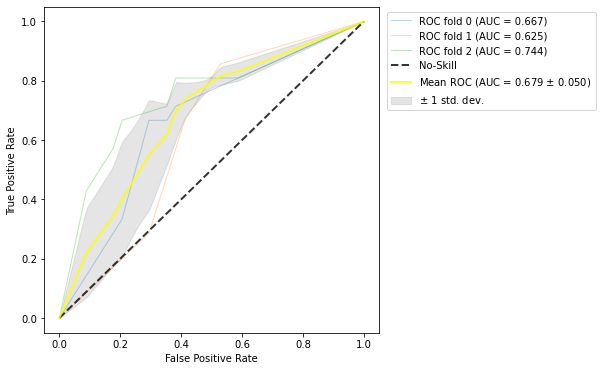

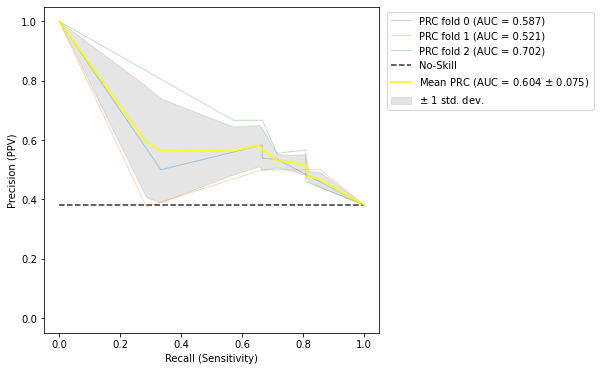

Generating ROC and PRC plots...


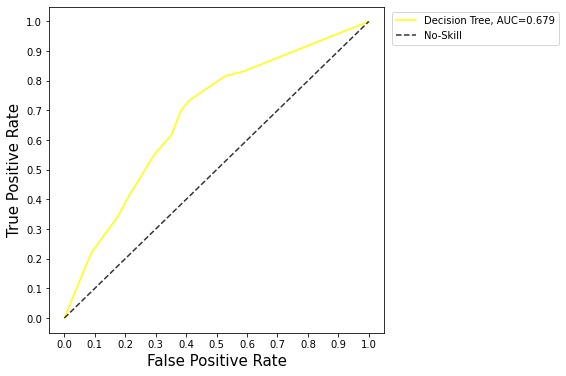

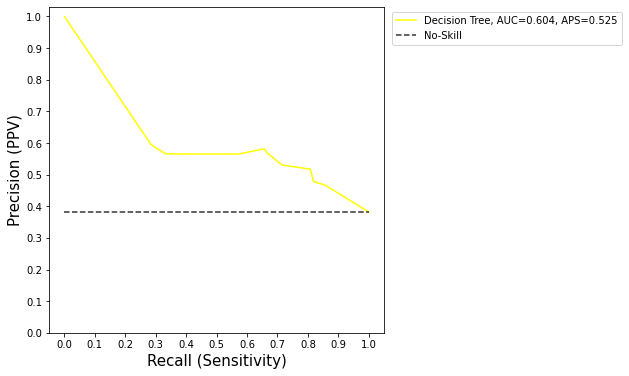

Saving Metric Summaries...
Generating Metric Boxplots...


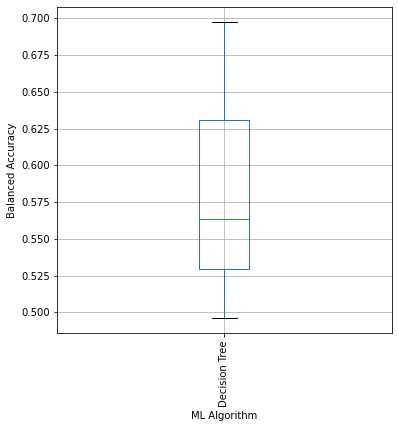

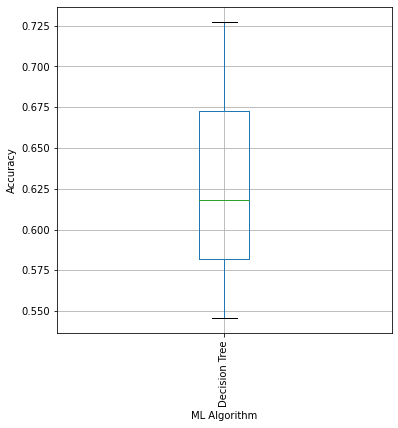

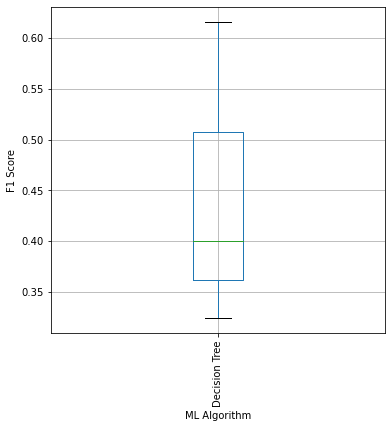

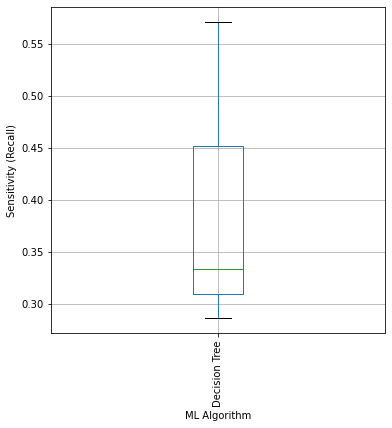

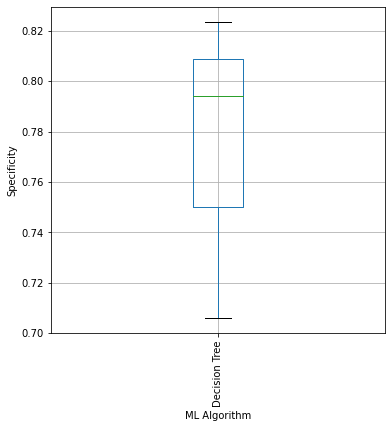

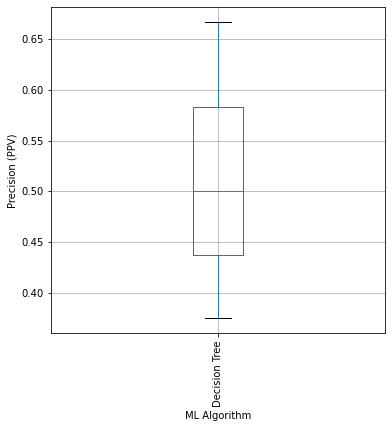

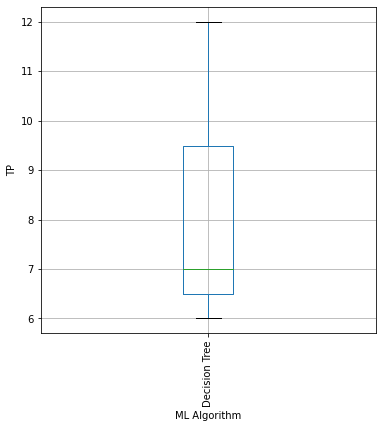

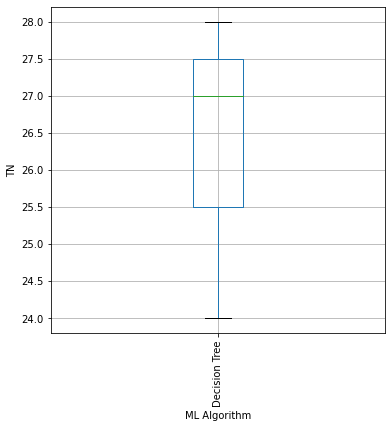

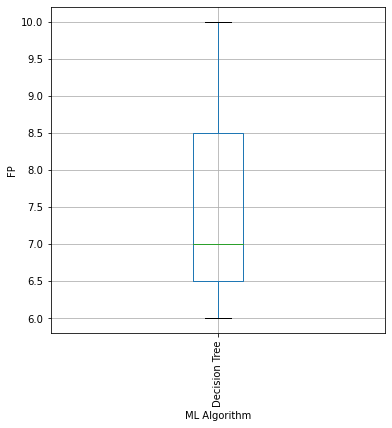

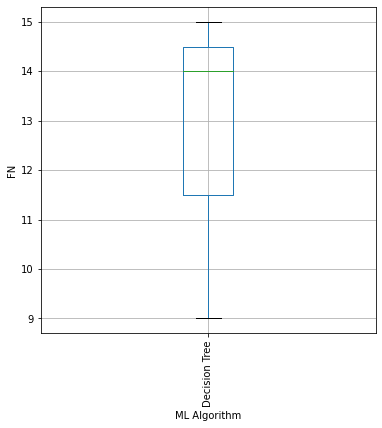

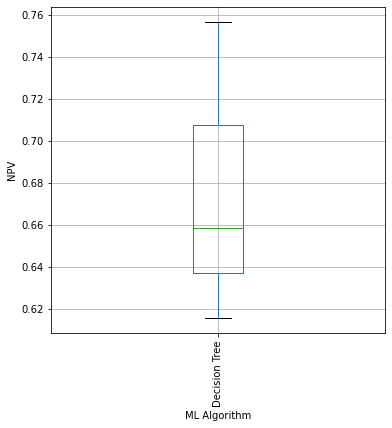

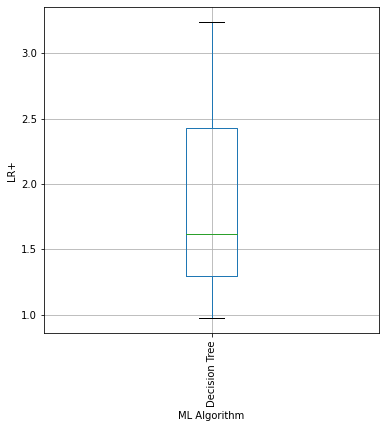

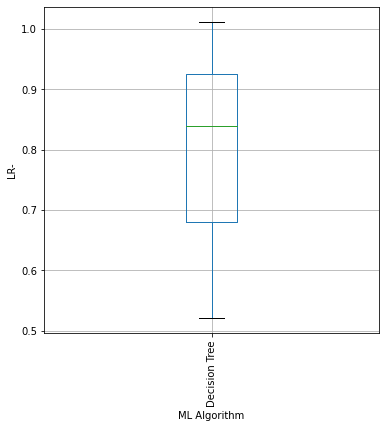

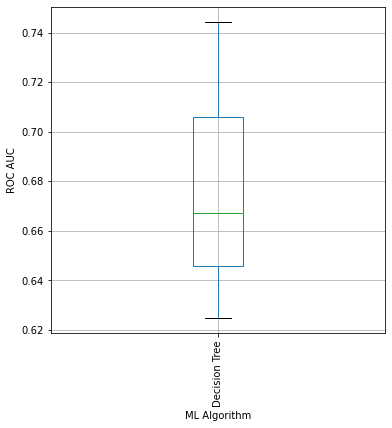

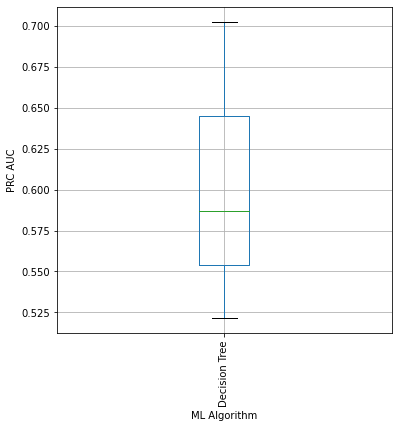

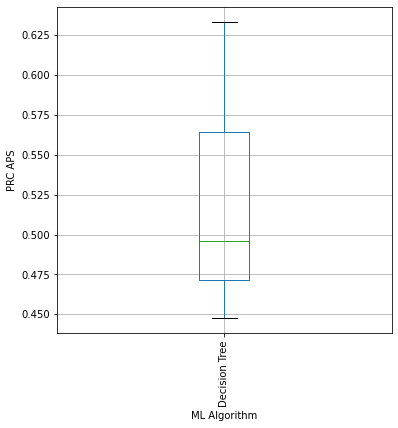

Preparing for Model Feature Importance Plotting...
Generating Feature Importance Boxplots and Histograms...


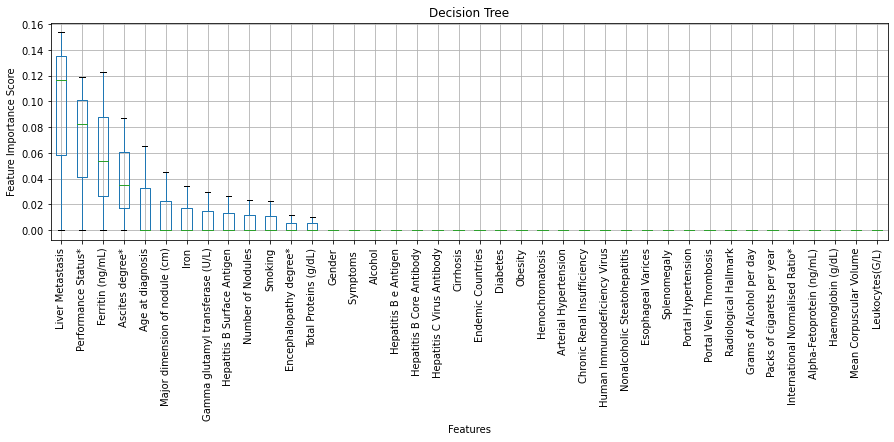

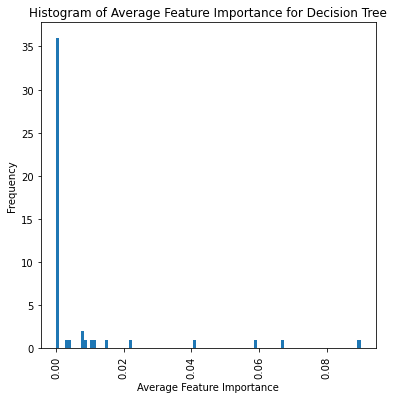

Generating Composite Feature Importance Plots...


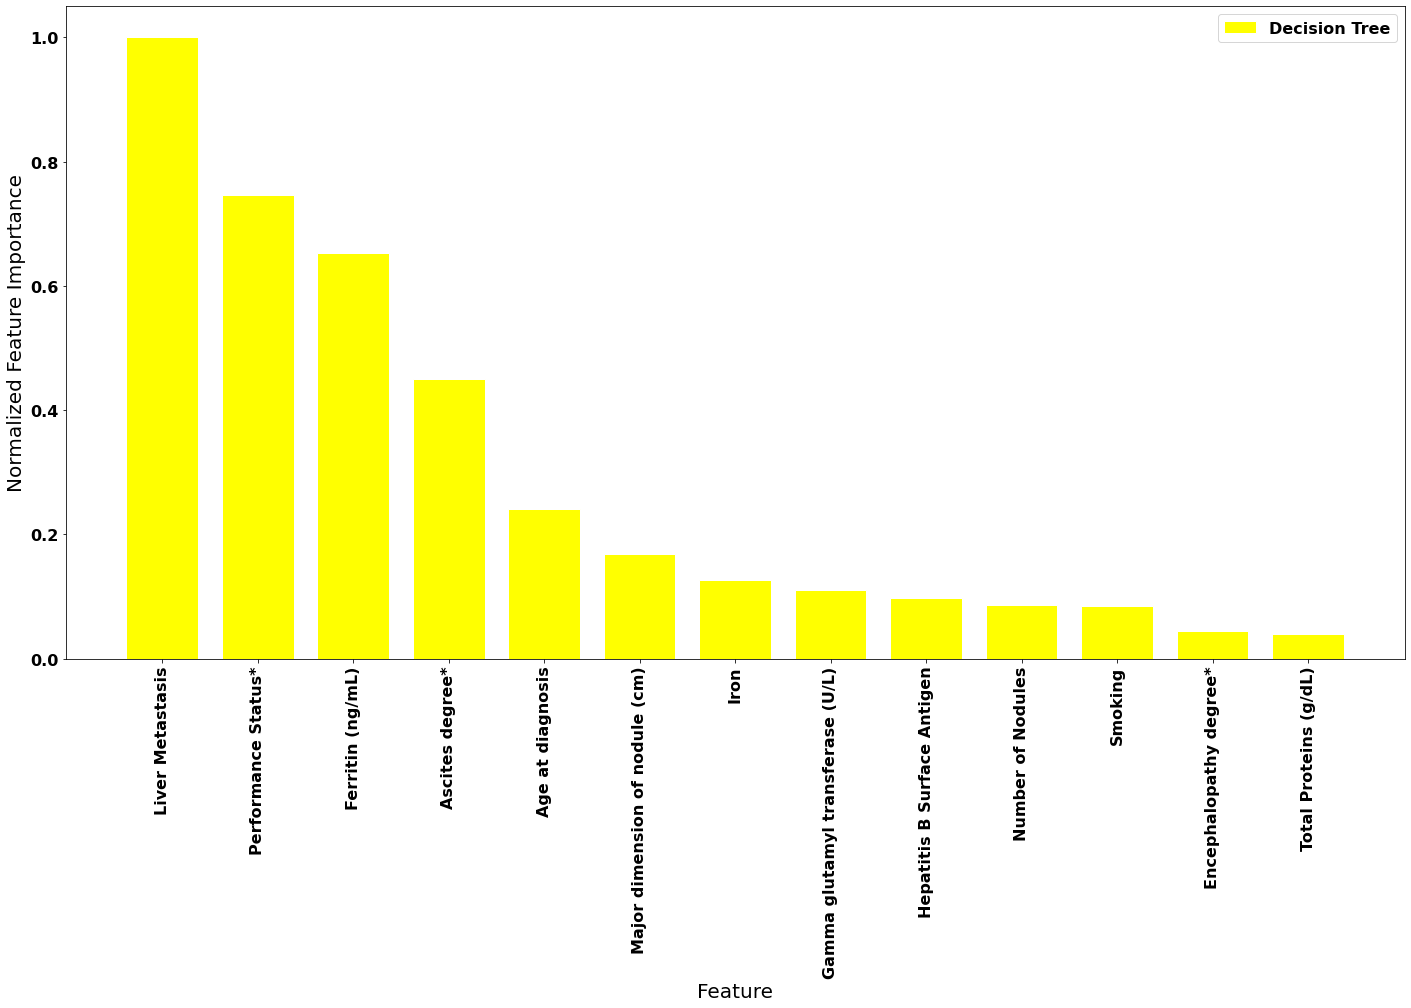

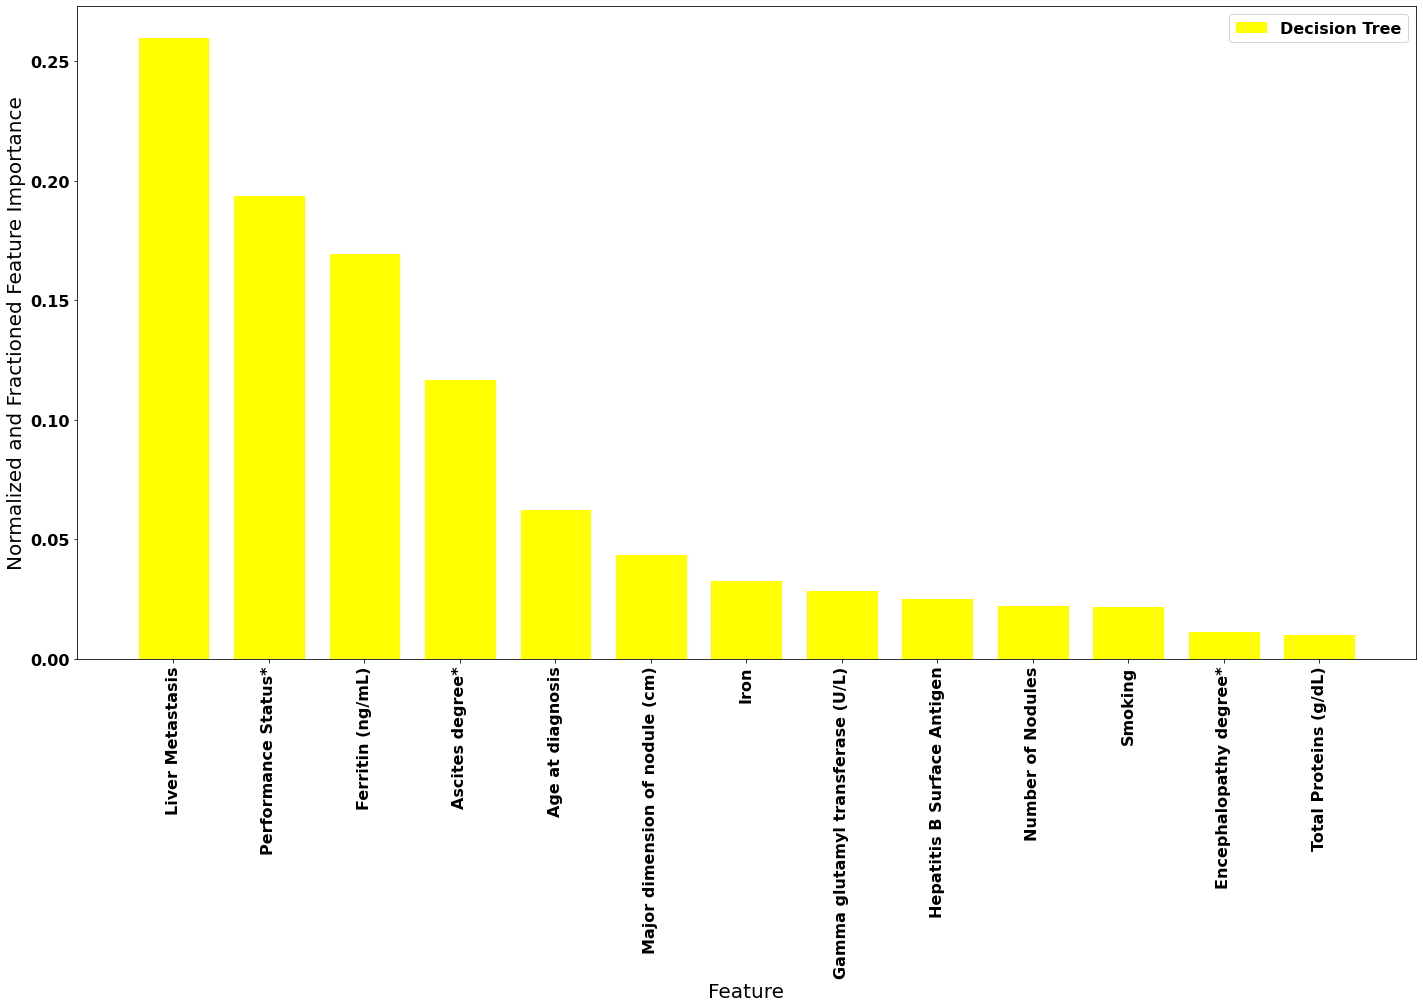

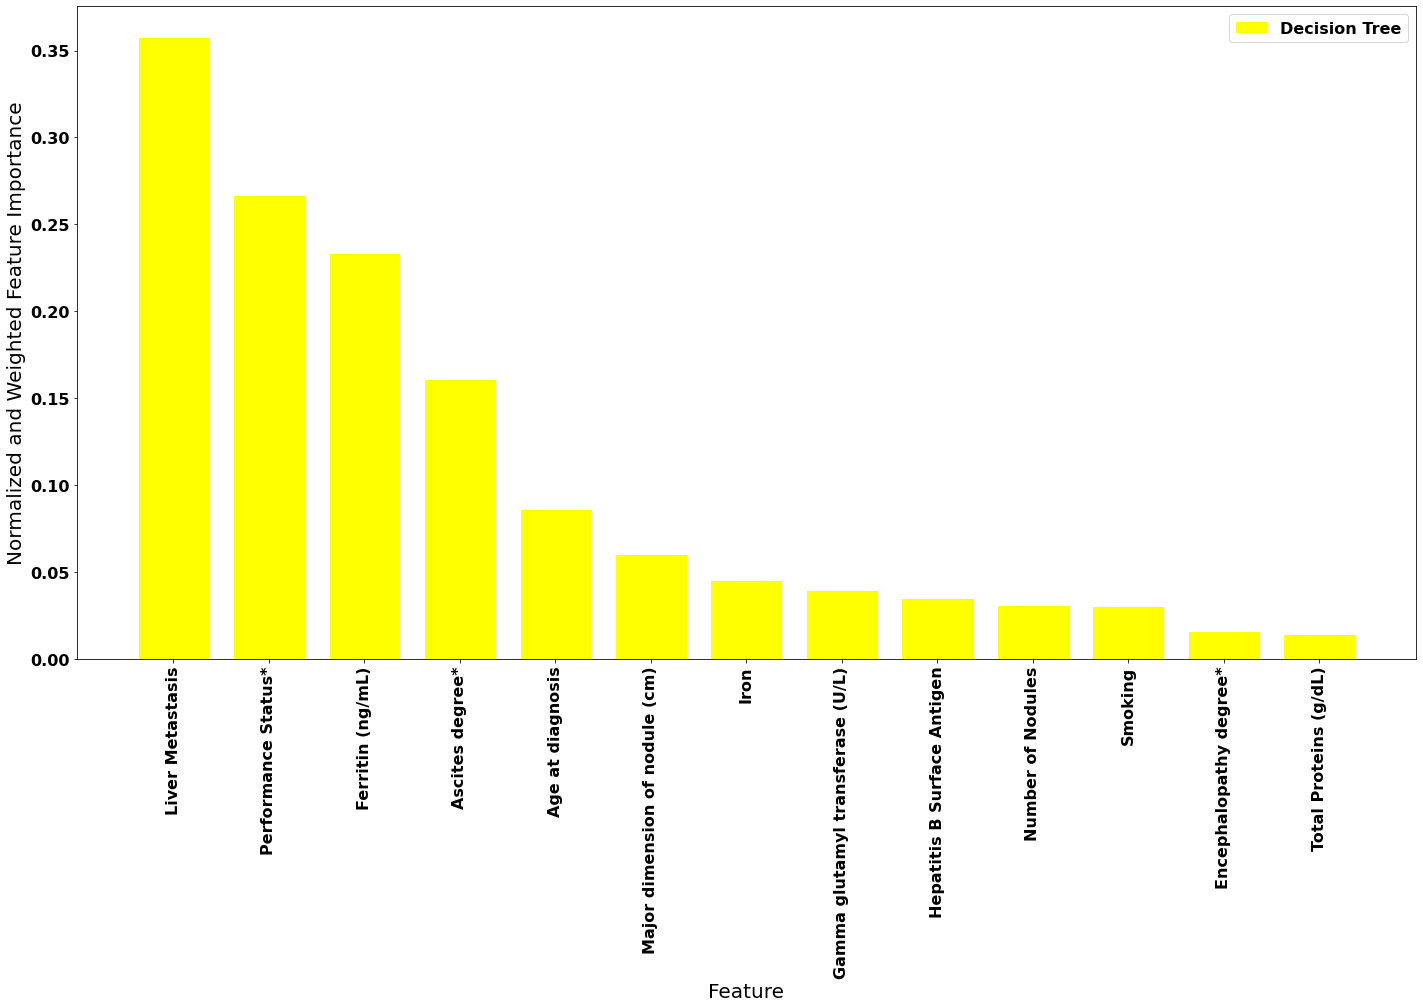

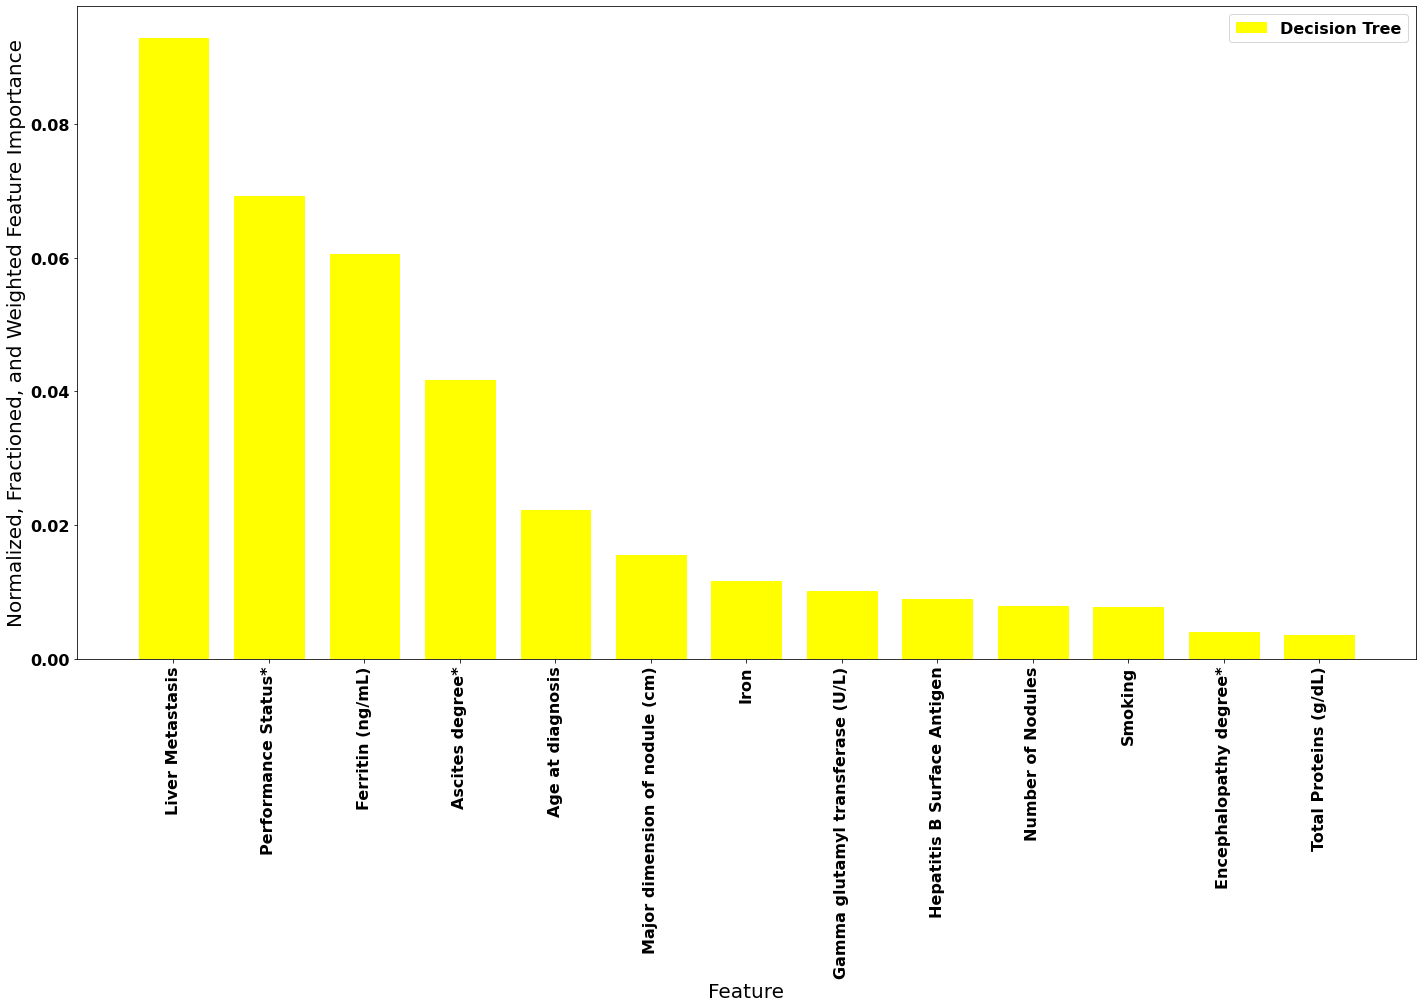

hcc-data_example phase 5 complete
Running Statistics Summary for hcc-data_example_no_covariates
Decision Tree


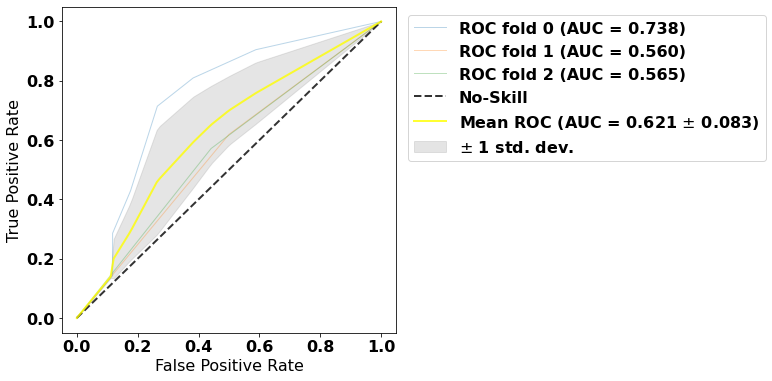

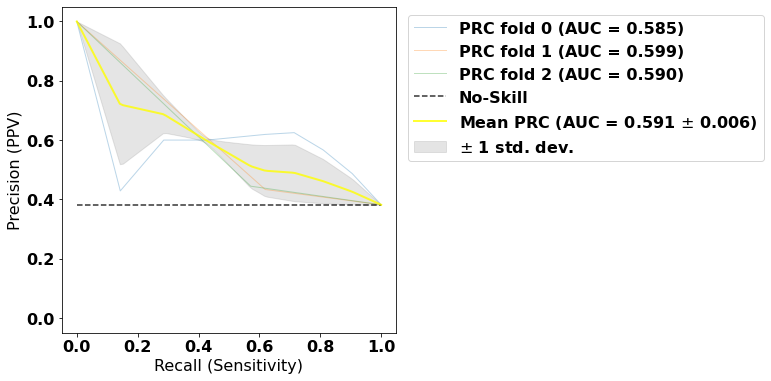

Generating ROC and PRC plots...


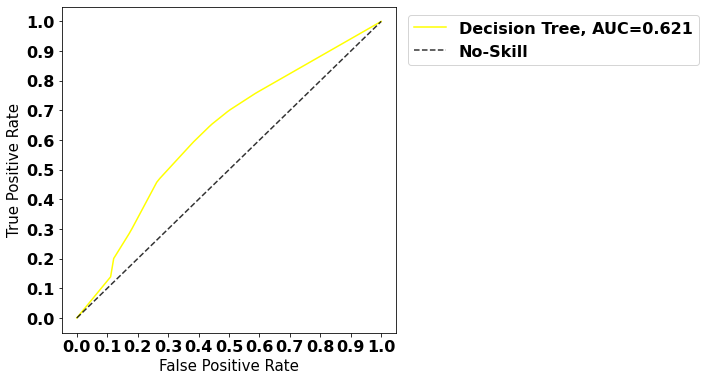

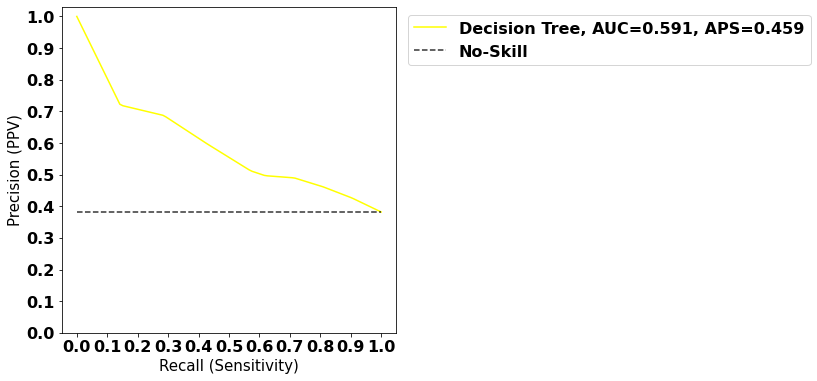

Saving Metric Summaries...
Generating Metric Boxplots...


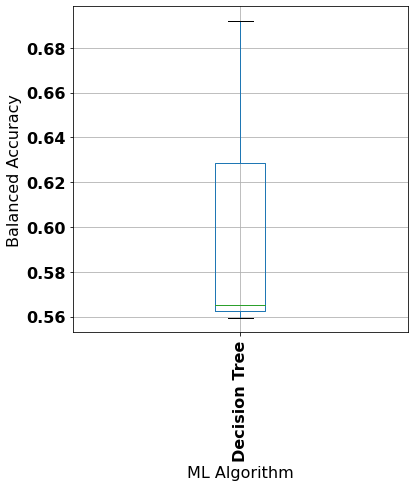

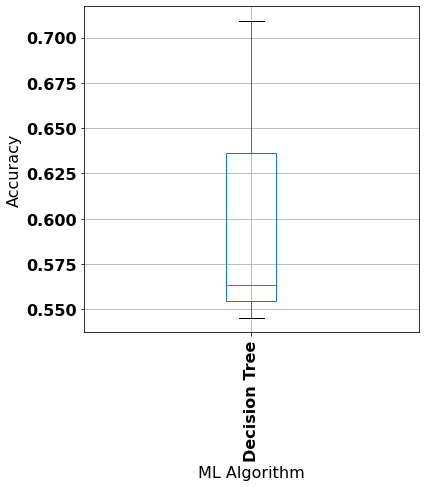

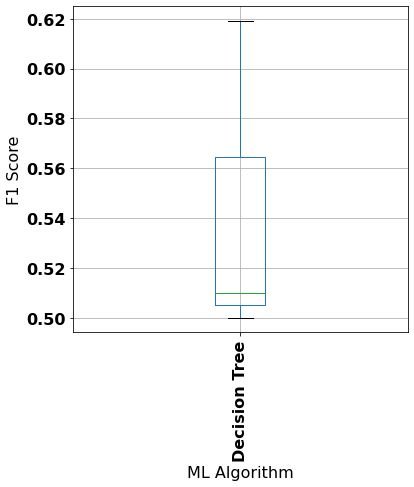

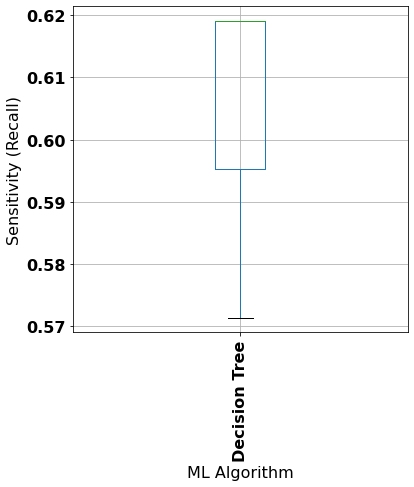

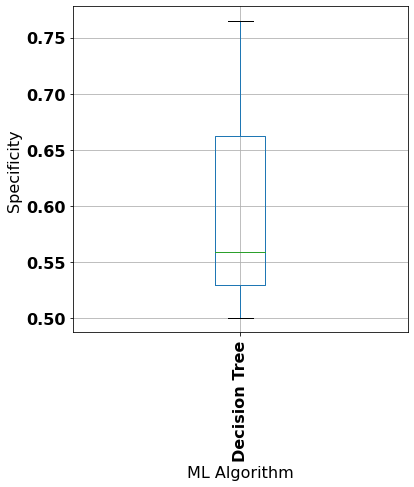

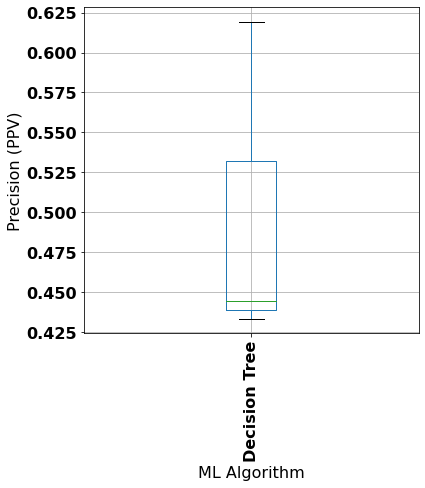

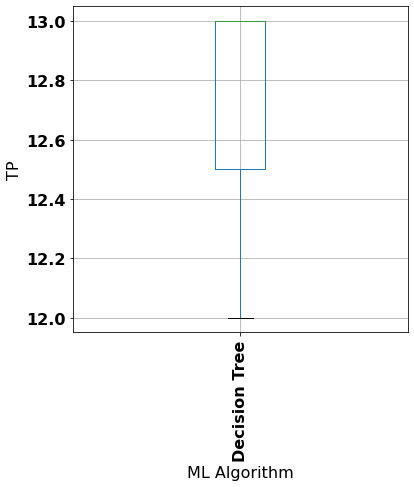

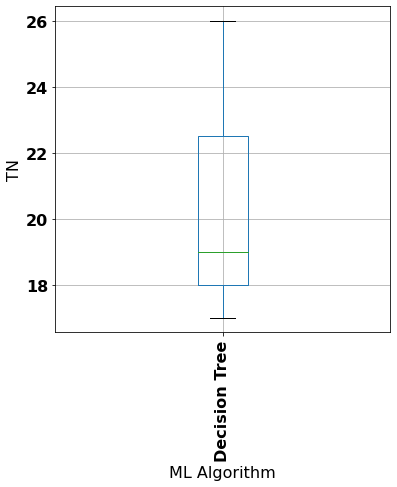

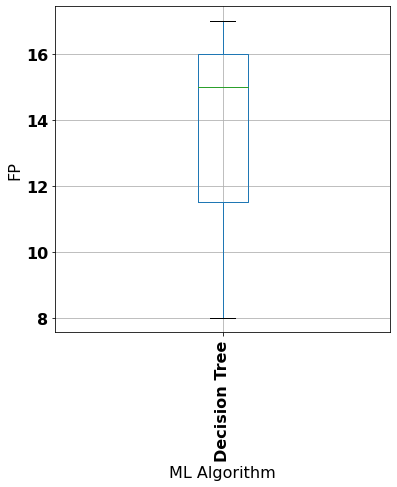

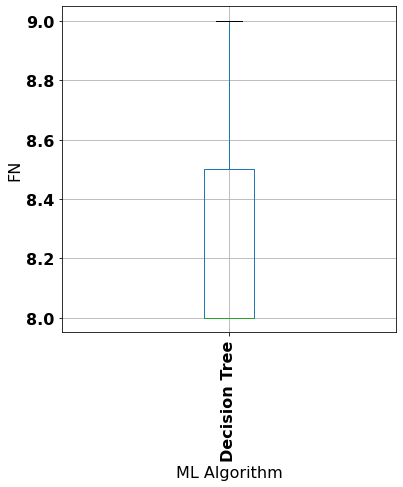

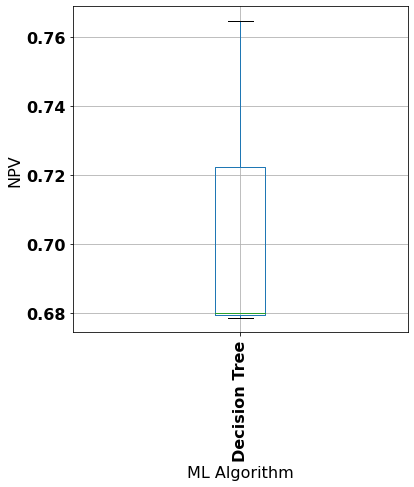

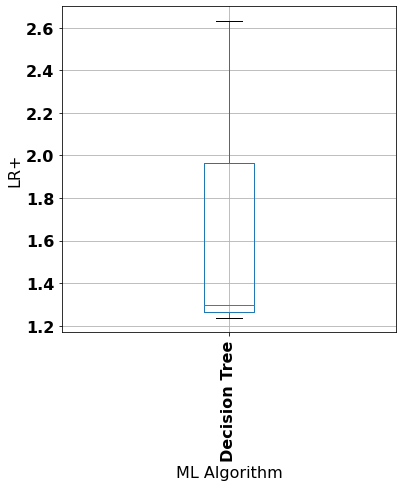

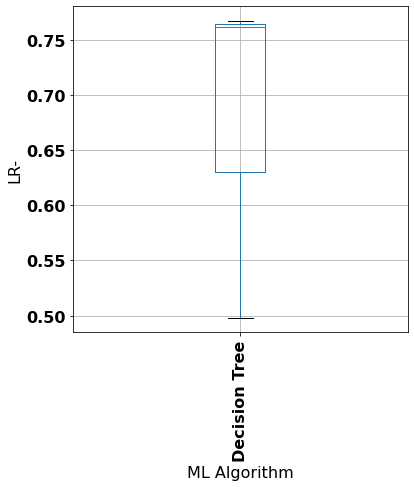

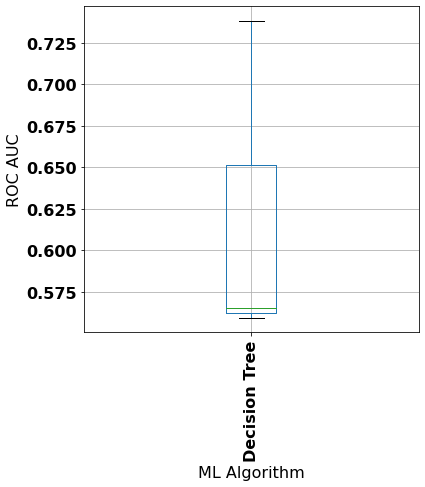

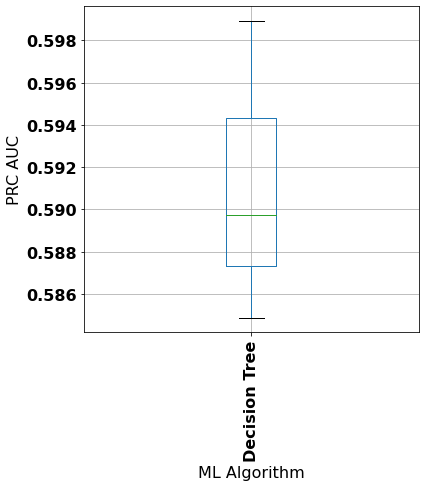

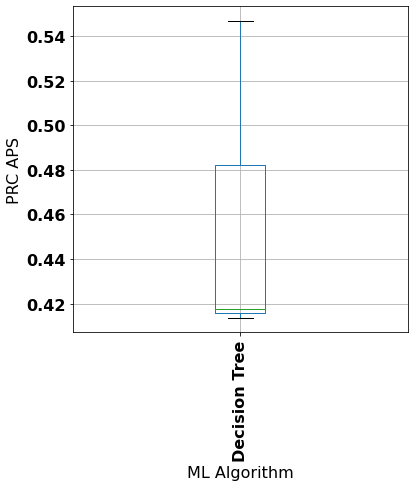

Preparing for Model Feature Importance Plotting...
Generating Feature Importance Boxplots and Histograms...


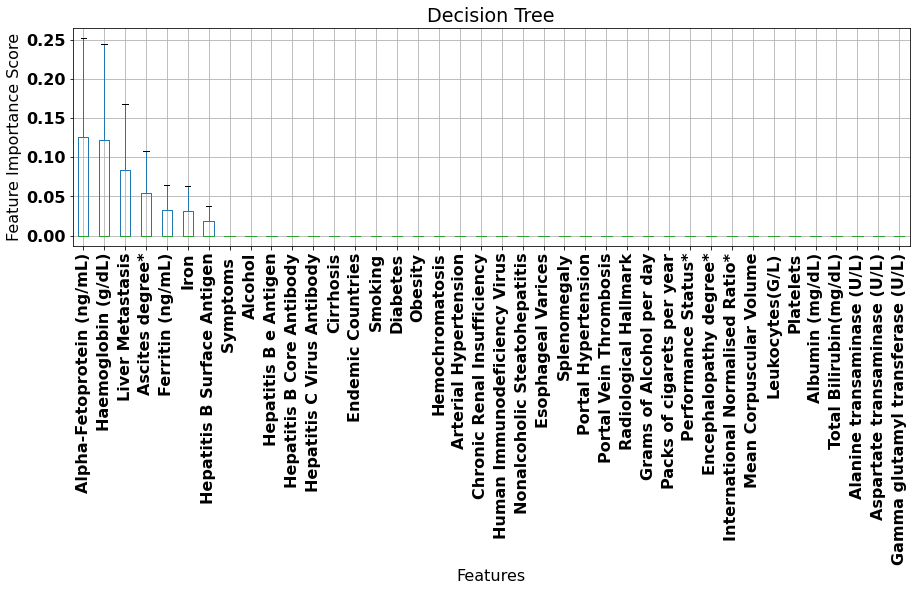

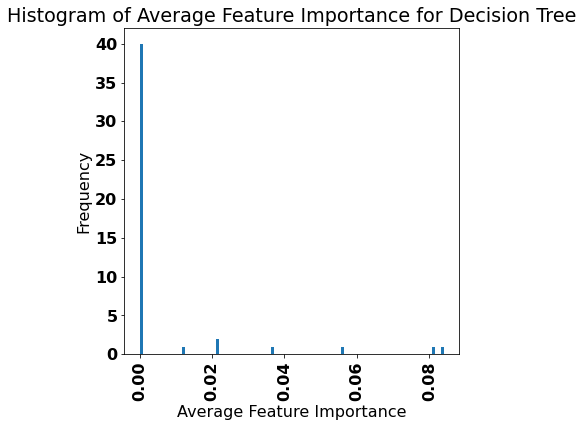

Generating Composite Feature Importance Plots...


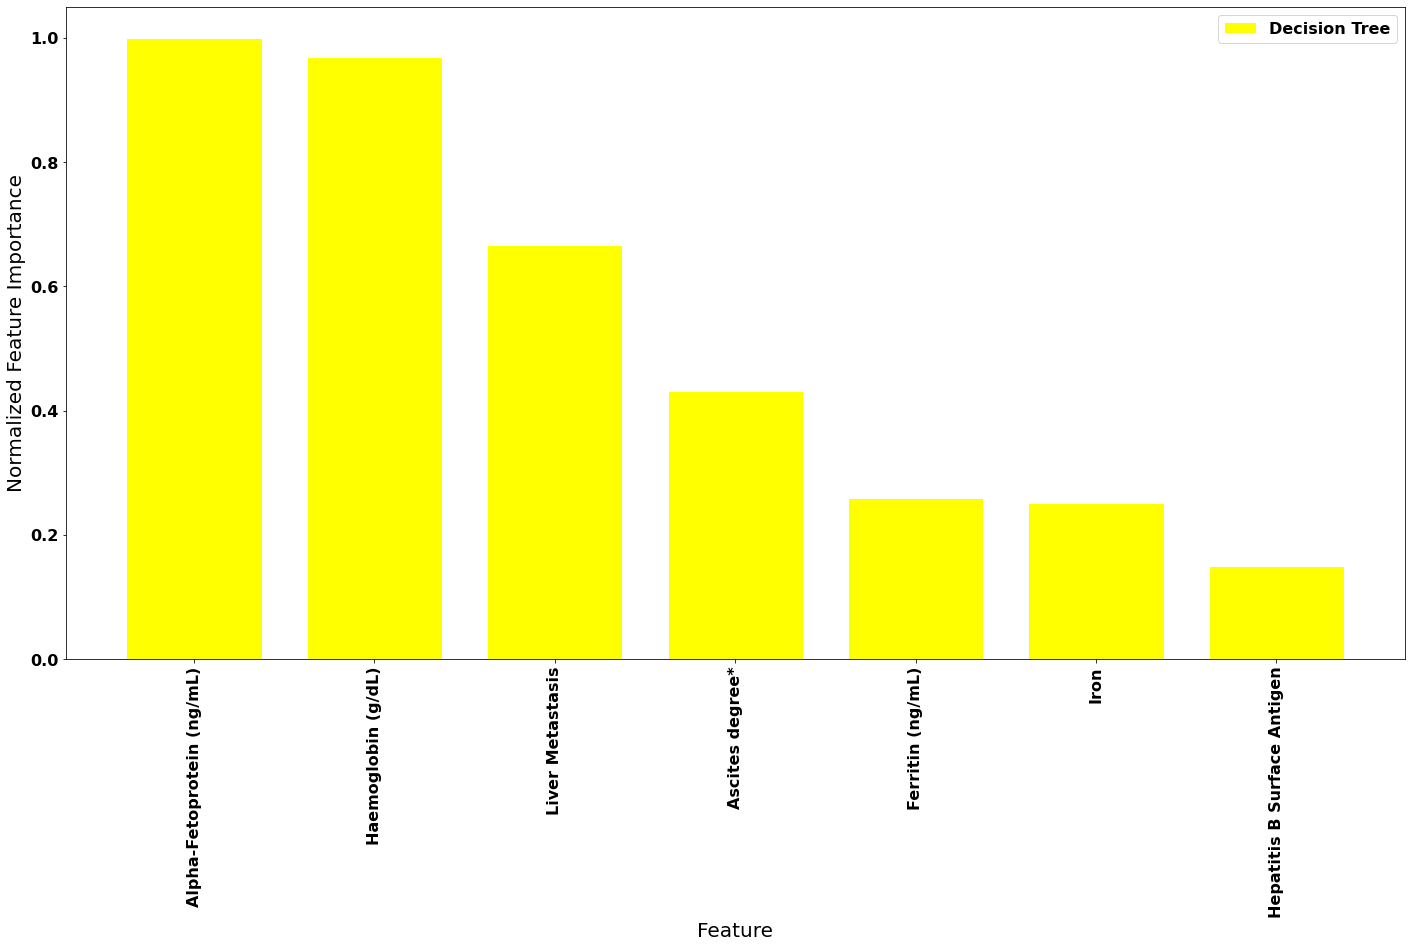

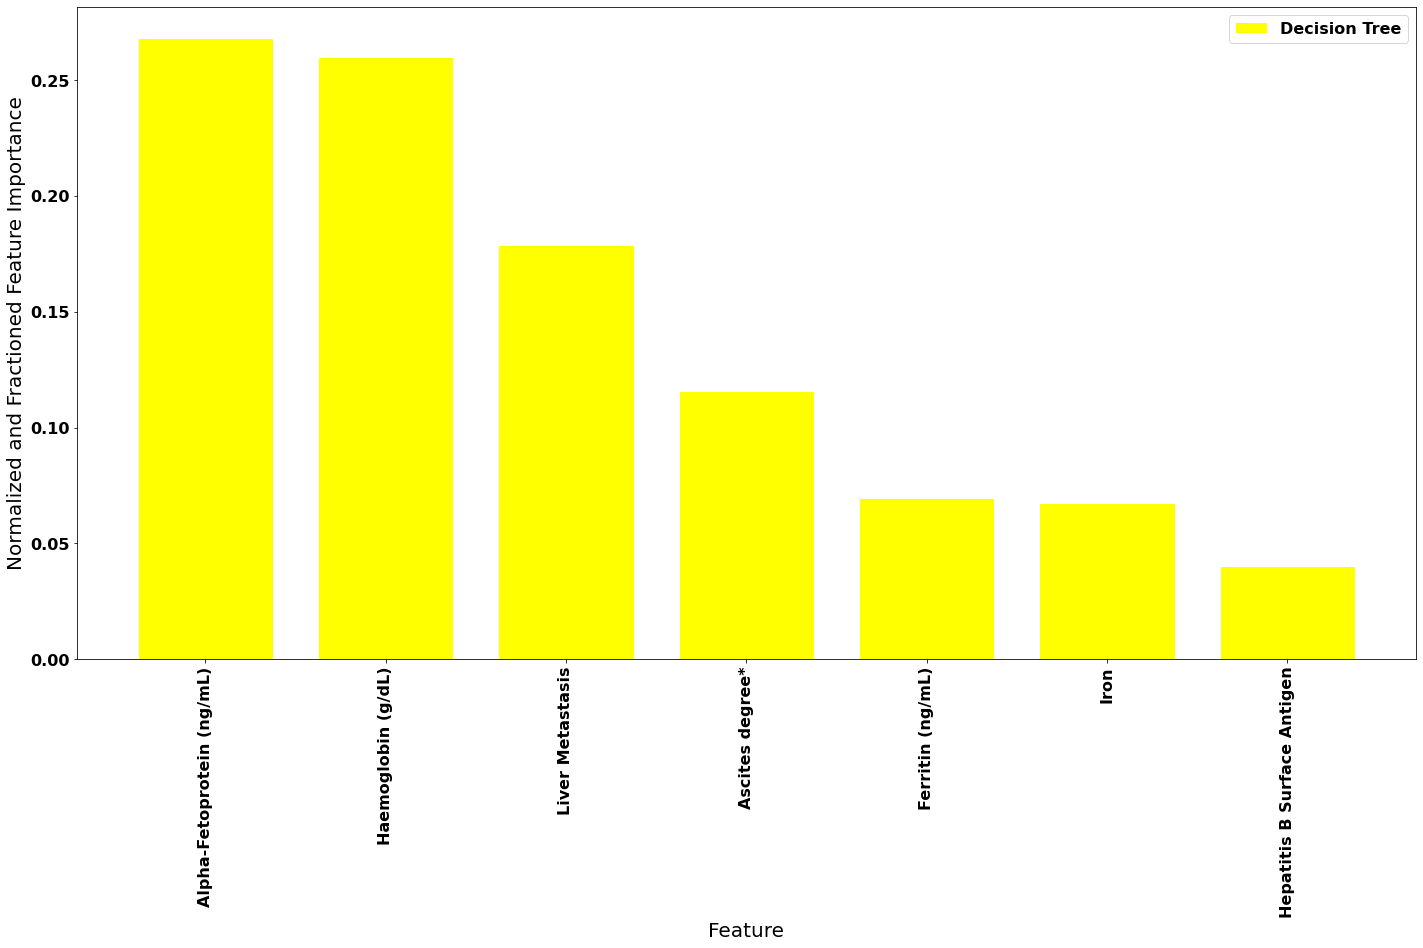

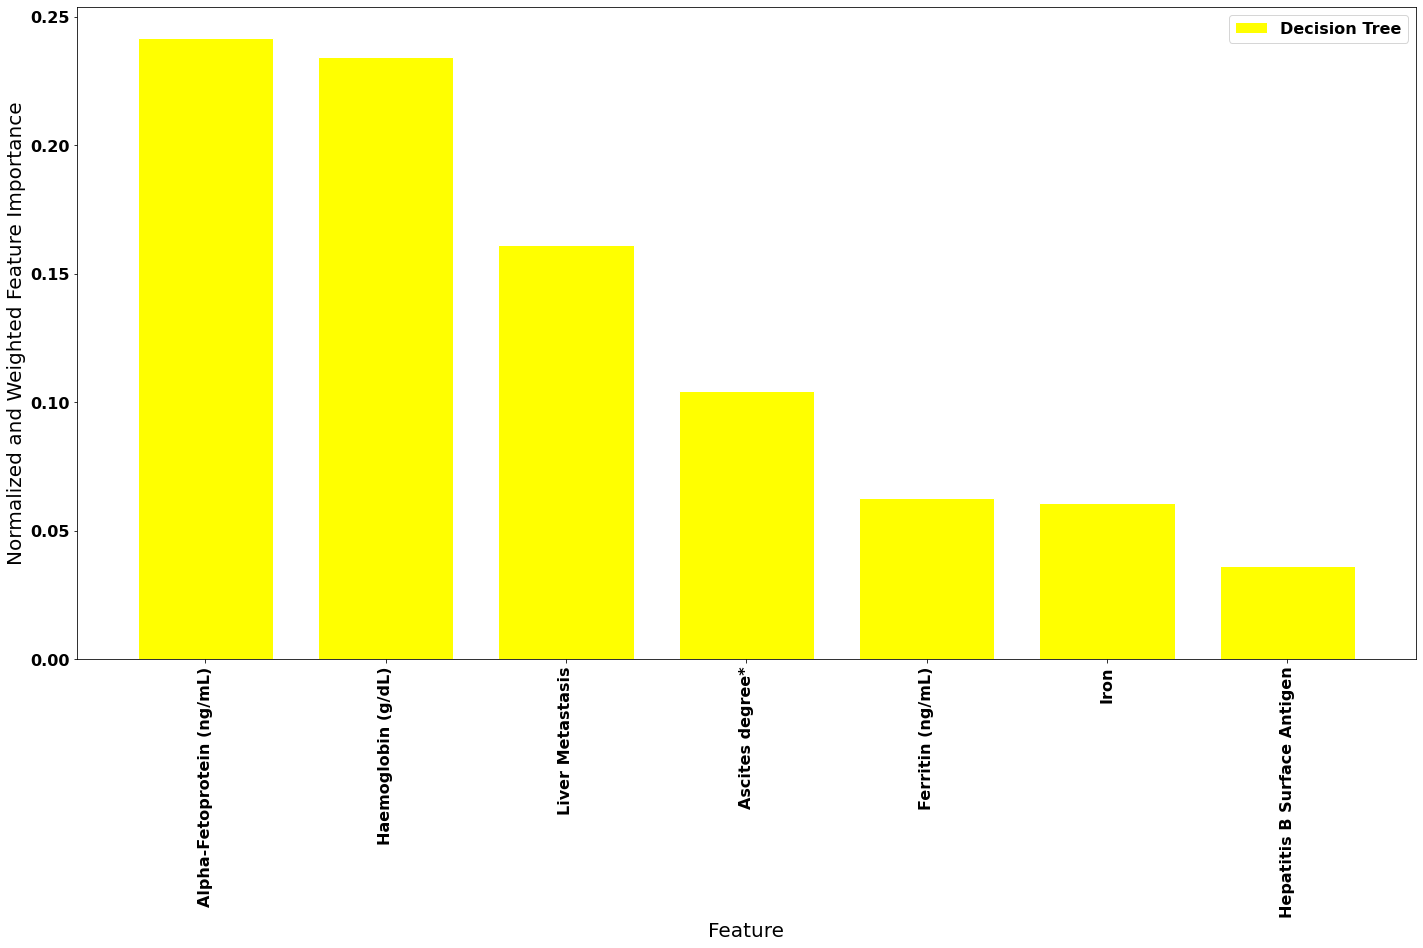

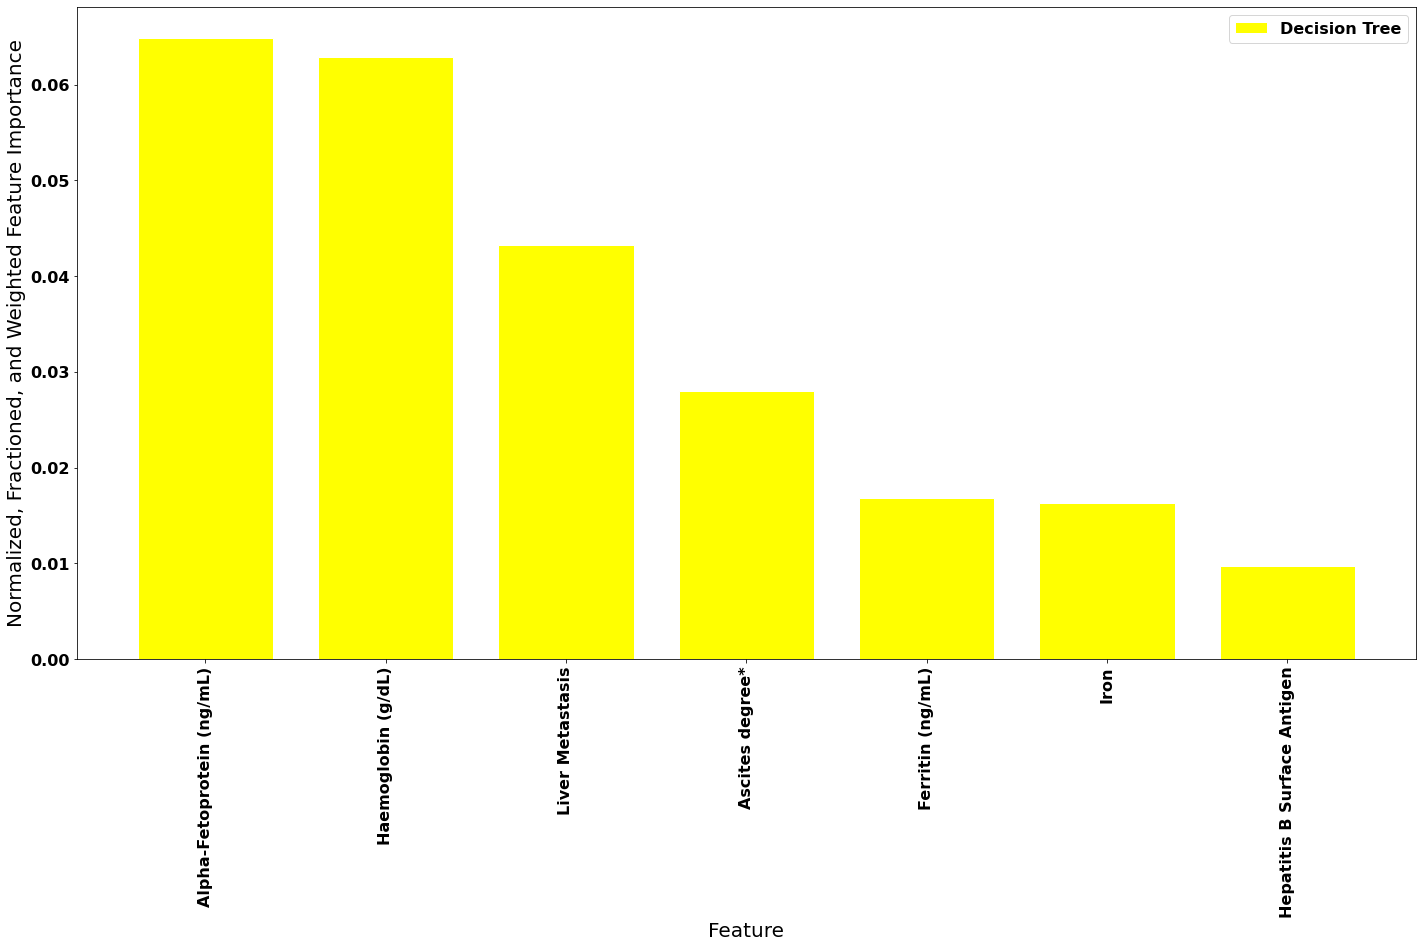

hcc-data_example_no_covariates phase 5 complete


In [27]:
#Unpickle metadata from previous phase
file = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'rb')
metadata = pickle.load(file)
file.close()
metadata['Export ROC Plot'] = plot_ROC
metadata['Export PRC Plot'] = plot_PRC
metadata['Export Metric Boxplots'] = plot_metric_boxplots
metadata['Export Feature Importance Boxplots'] = plot_FI_box
metadata['Metric Weighting Composite FI Plots'] = metric_weight
metadata['Top Model Features To Display'] = top_model_features
#Pickle the metadata for future use
pickle_out = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'wb')
pickle.dump(metadata,pickle_out)
pickle_out.close()

#Now that primary pipeline phases are complete generate a human readable version of metadata
df = pd.DataFrame.from_dict(metadata, orient ='index')
df.to_csv(output_path+'/'+experiment_name+'/'+'metadata.csv',index=True)

# Iterate through datasets
dataset_paths = os.listdir(output_path + "/" + experiment_name)
removeList = removeList = ['metadata.pickle','metadata.csv','algInfo.pickle','jobsCompleted','logs','jobs','DatasetComparisons','UsefulNotebooks',experiment_name+'_ML_Pipeline_Report.pdf']
for text in removeList:
    if text in dataset_paths:
        dataset_paths.remove(text)
for dataset_directory_path in dataset_paths:
    full_path = output_path + "/" + experiment_name + "/" + dataset_directory_path
    StatsJob.job(full_path,plot_ROC,plot_PRC,plot_FI_box,class_label,instance_label,cv_partitions,scale_data,plot_metric_boxplots,primary_metric,top_model_features,sig_cutoff,metric_weight,jupyterRun)

## -----------------------------------------------------------------------------------------------------------------
## Phase 7: Dataset Comparison (Optional: Use only if > 1 dataset was analyzed)

### Import Additional Python Packages

In [28]:
import DataCompareJob

### Run Dataset Comparison

Running Statistical Significance Comparisons Between Multiple Datasets...
Generate Boxplots Comparing Dataset Performance...


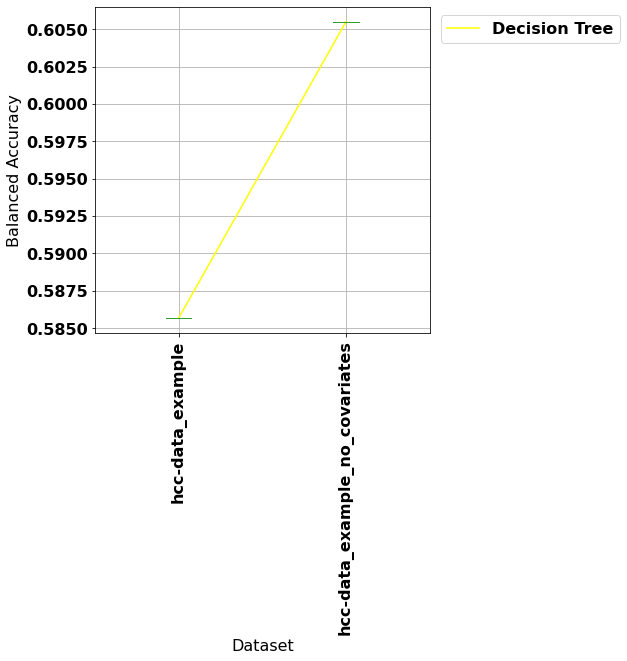

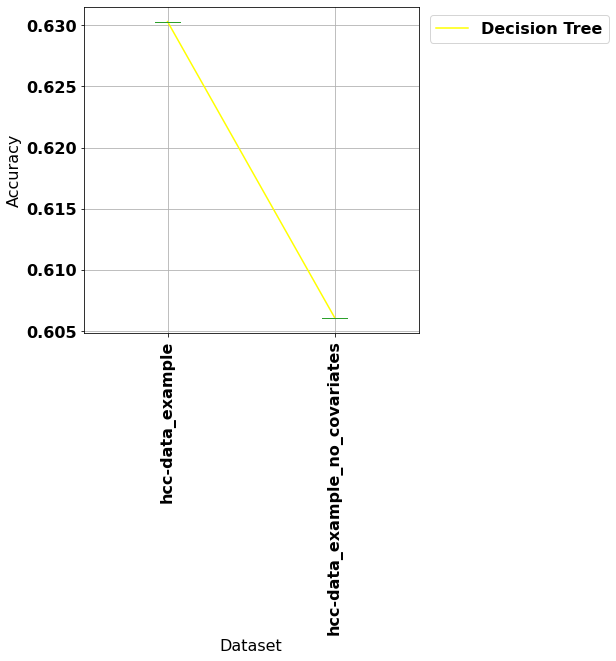

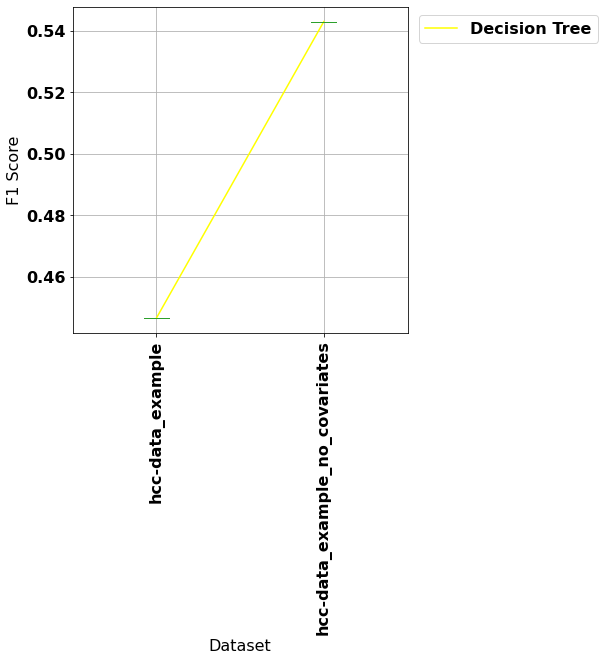

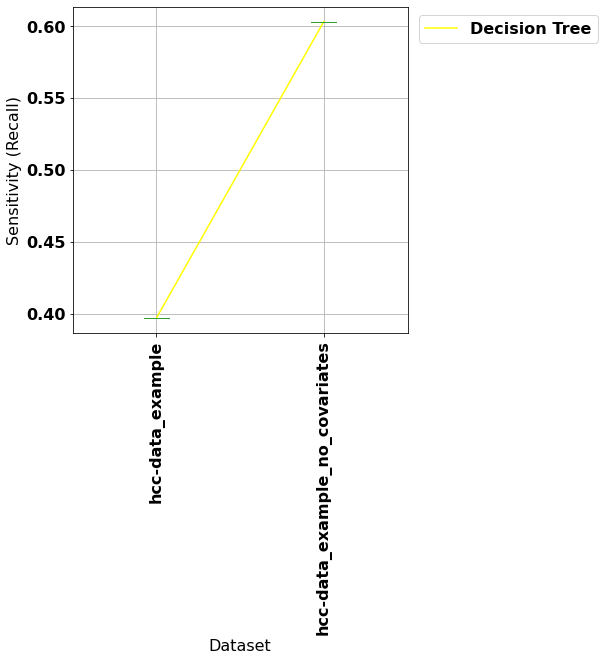

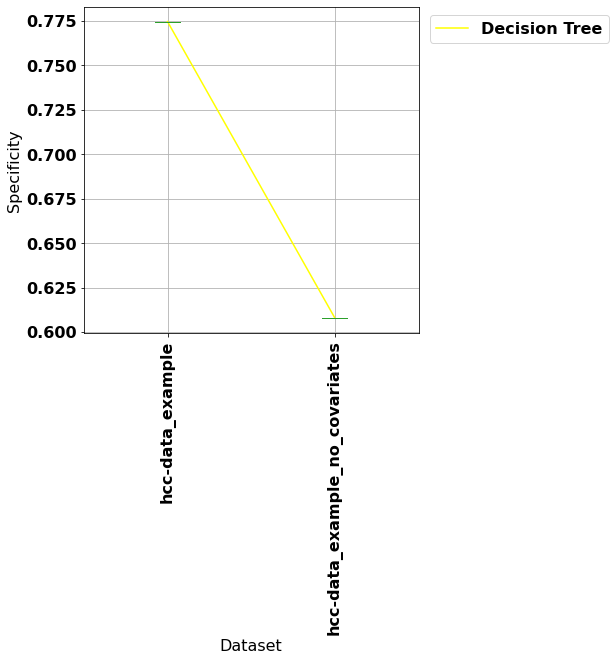

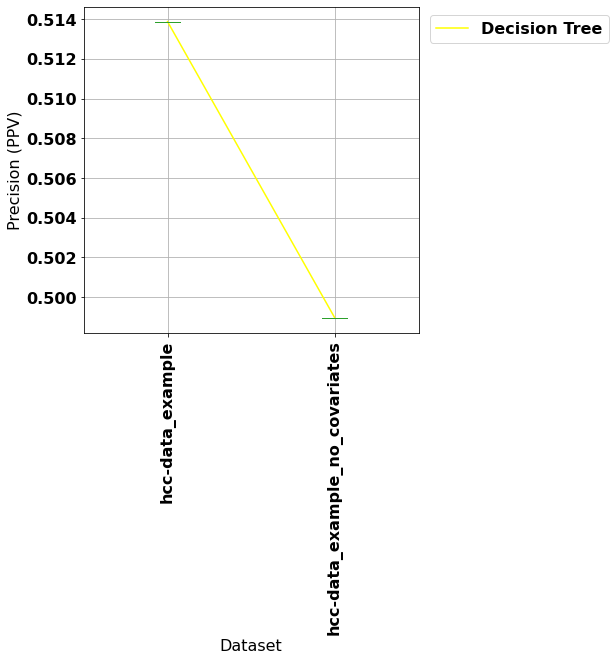

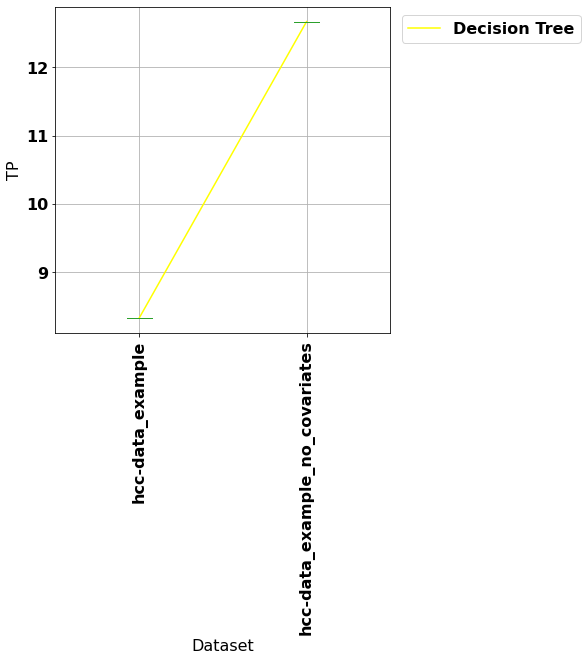

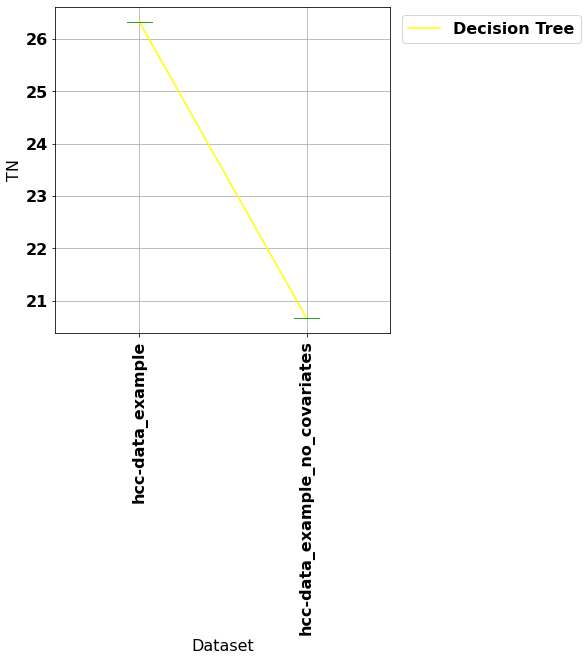

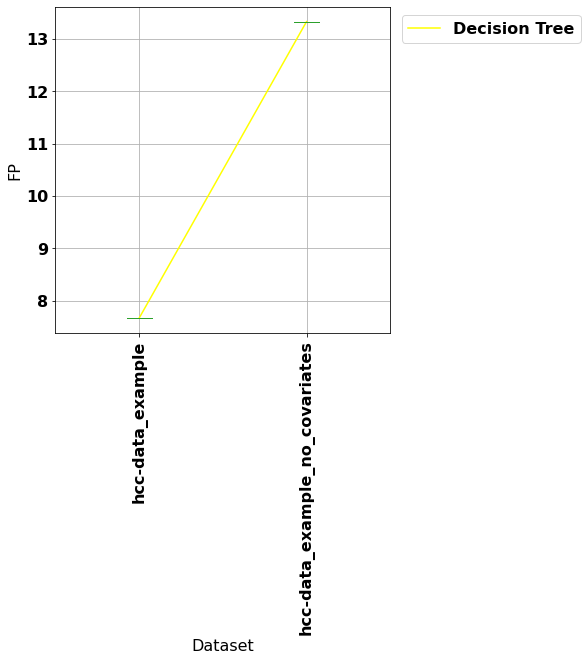

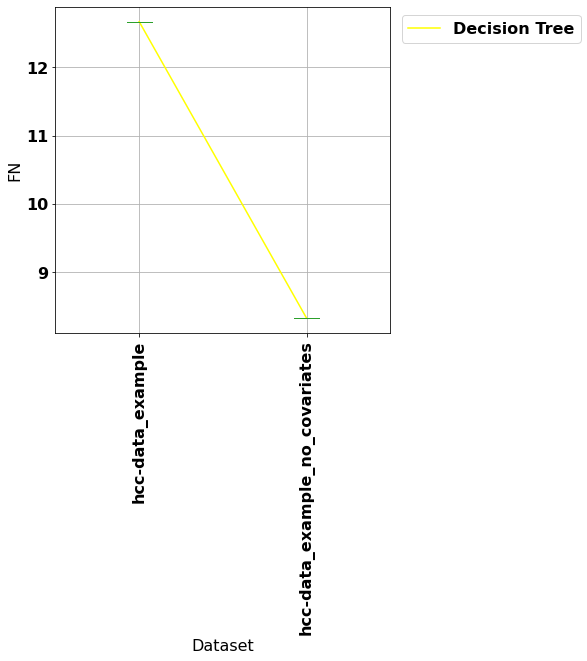

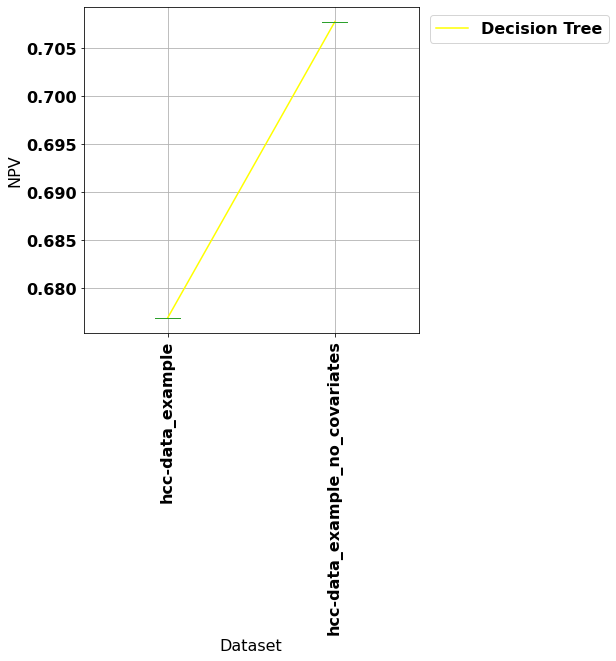

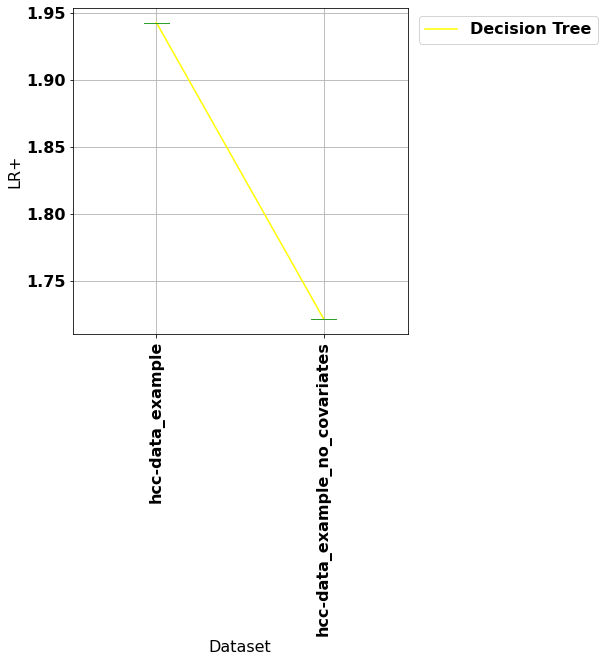

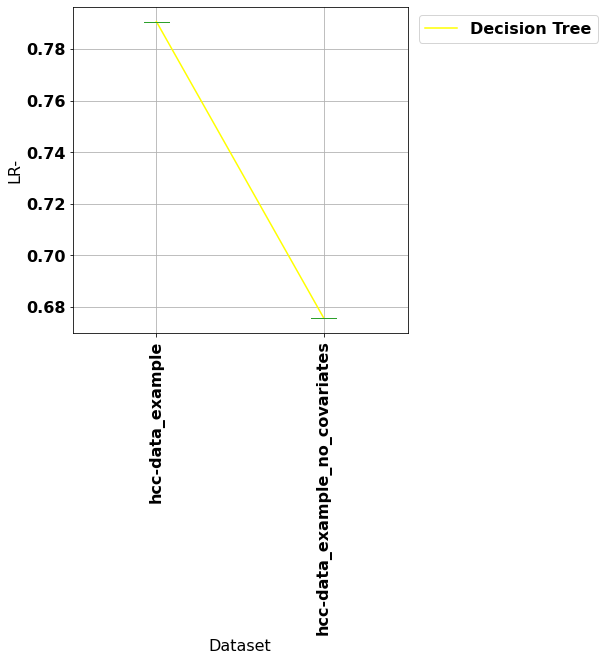

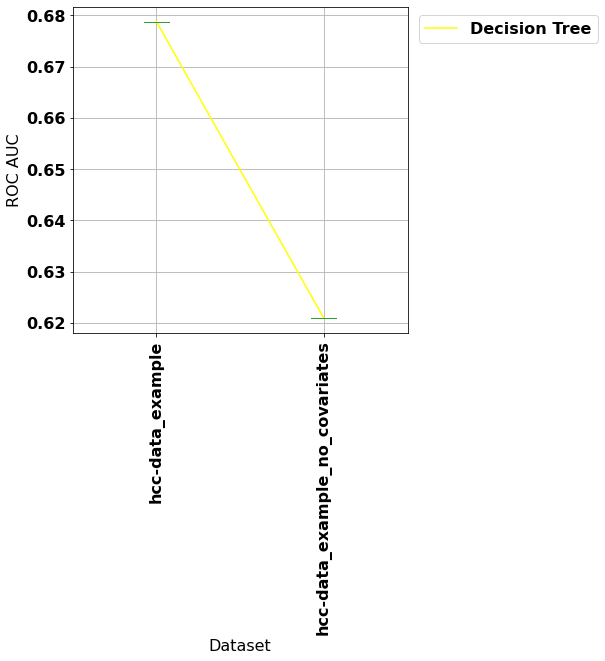

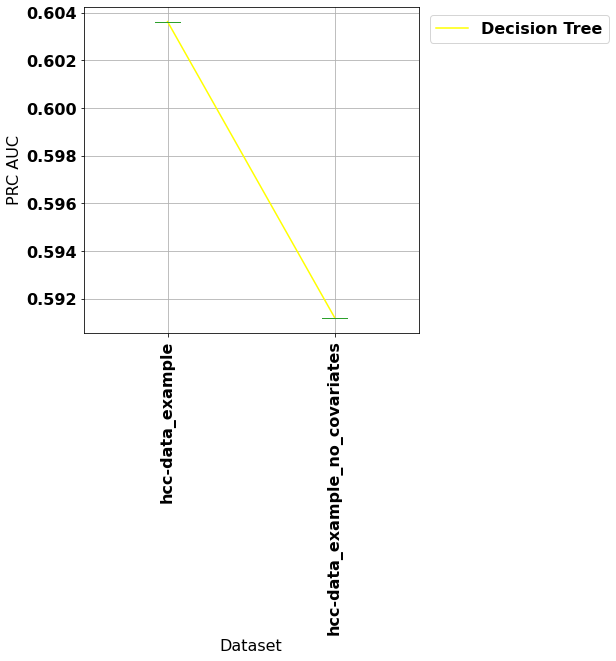

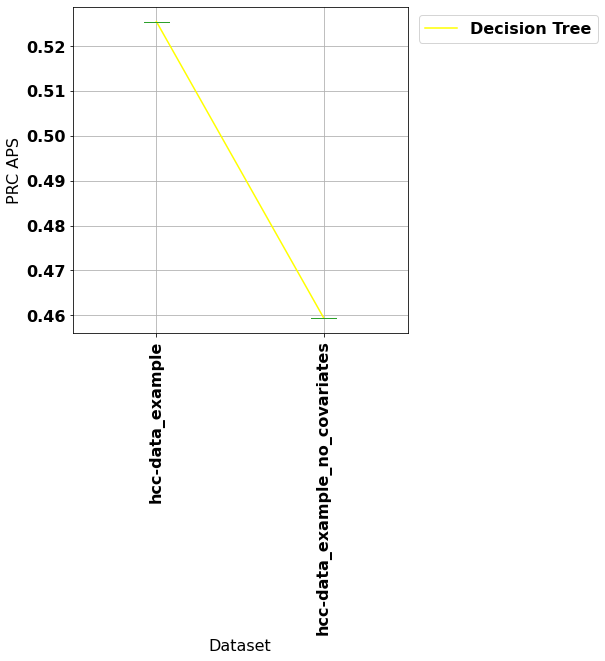

Decision Tree


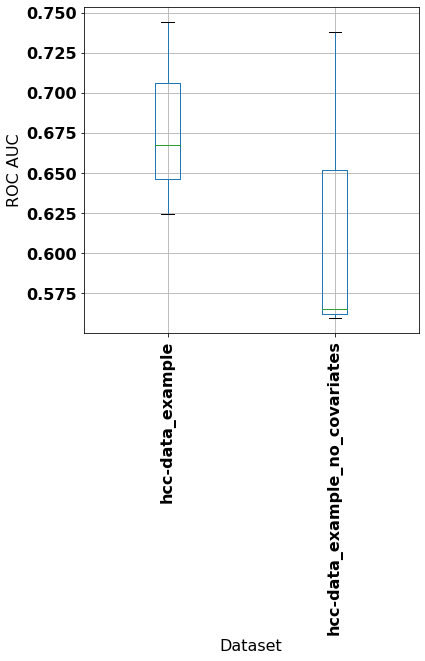

Decision Tree


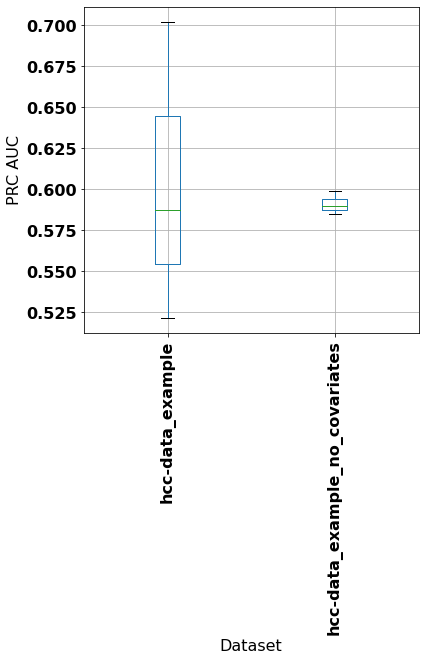

Phase 7 complete


In [29]:
if len(dataset_paths) > 1:
    DataCompareJob.job(output_path+'/'+experiment_name,sig_cutoff,jupyterRun)

## -----------------------------------------------------------------------------------------------------------------
## Phase 8: PDF Training Report Generator (Optional)

In [30]:
import PDF_ReportJob

In [31]:
experiment_path = output_path+'/'+experiment_name
PDF_ReportJob.job(experiment_path,'True','None','None')

2022-05-18 17:24:45.905442
Starting Report
Publishing Univariate Analysis
Publishing Model Prediction Summary
Publishing Average Model Prediction Statistics
Publishing Feature Importance Summaries
Publishing Dataset Comparison Boxplots
Publishing Statistical Analysis
Publishing Runtime Summary
Phase 8 complete


## -----------------------------------------------------------------------------------------------------------------
## Phase 9: Apply Models to Replication Data (Optional)

### Import Additional Python Packages

In [32]:
import ApplyModelJob

### Specify Run Parameters

In [33]:
if demo_run:
    rep_data_path = wd_path+'/DemoRepData'
    data_path_for_rep = wd_path+'/DemoData/hcc-data_example.csv'
print("Replication Data Folder Path: "+rep_data_path)
print("Dataset Path: "+data_path_for_rep)

Replication Data Folder Path: C:/Users/UrbanowiczR/Documents/GitHub/STREAMLINE/DemoRepData
Dataset Path: C:/Users/UrbanowiczR/Documents/GitHub/STREAMLINE/DemoData/hcc-data_example.csv


### Run Application of Models to Replication Data

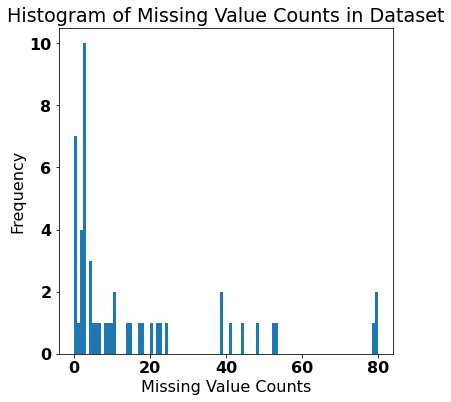

Data Counts: ----------------
Instance Count = 165
Feature Count = 49
    Categorical  = 27
    Quantitative = 22
Missing Count = 826
    Missing Percent = 0.10216450216450217
Class Counts: ----------------
0    102
1     63
Name: Class, dtype: int64


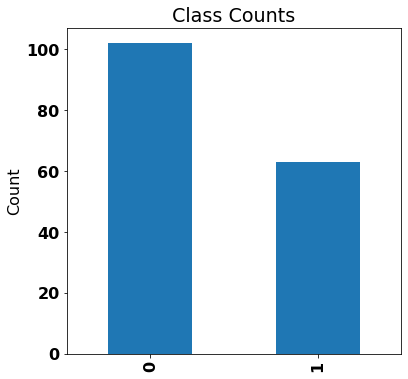

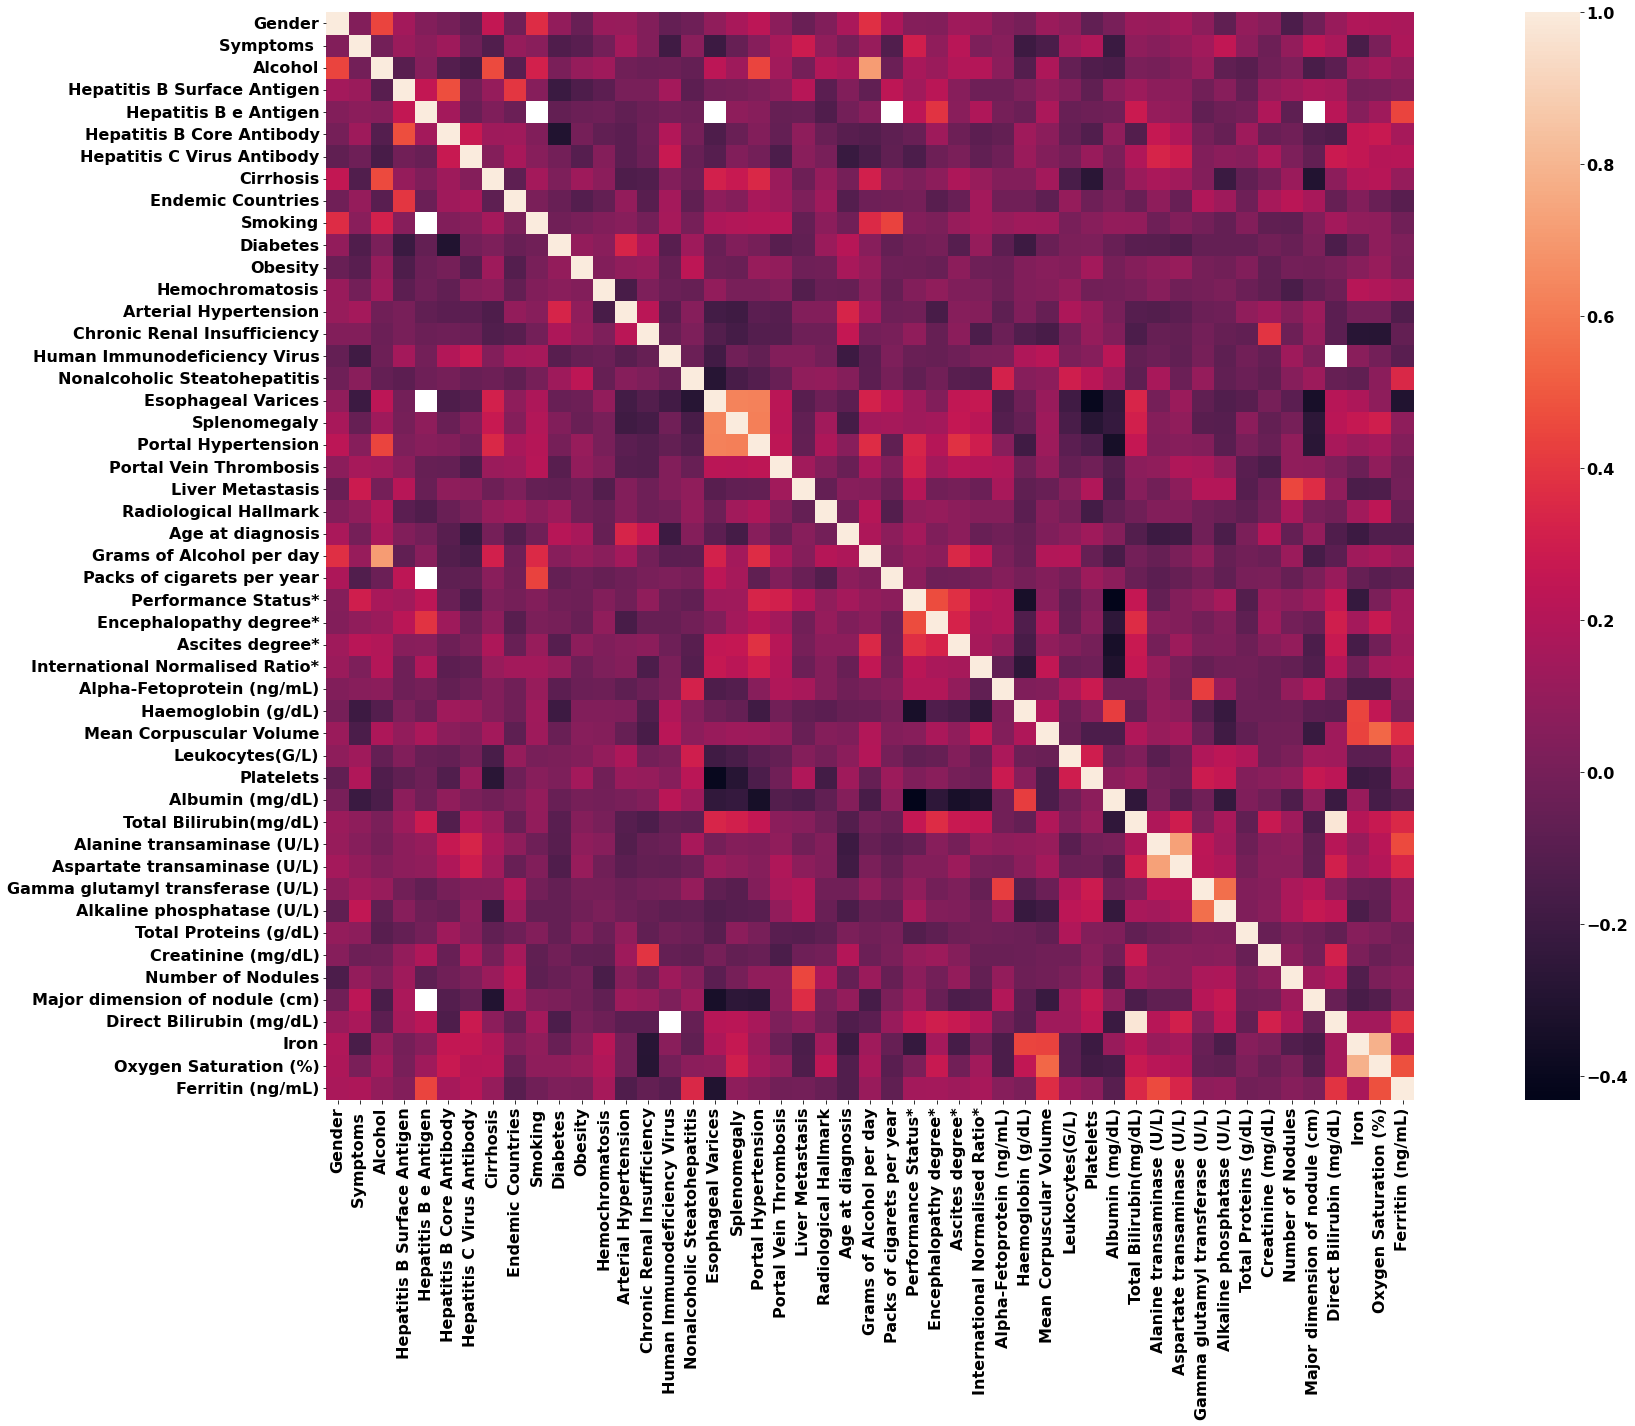

Decision Tree


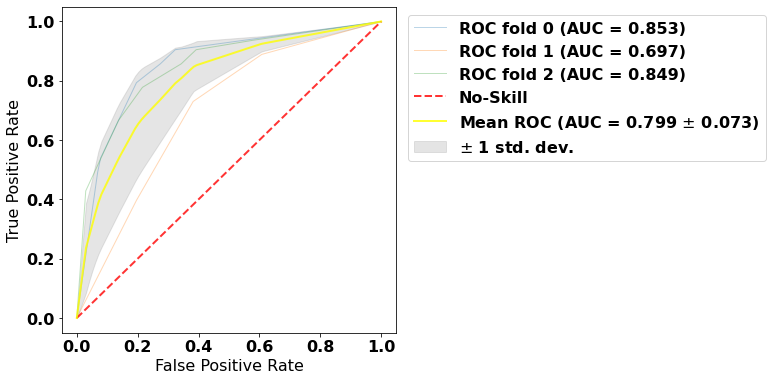

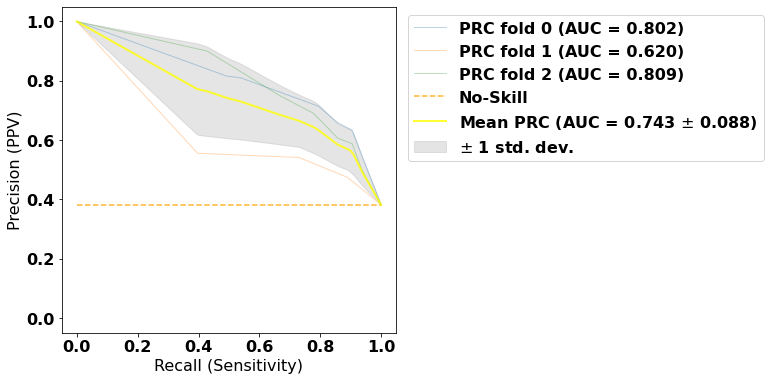

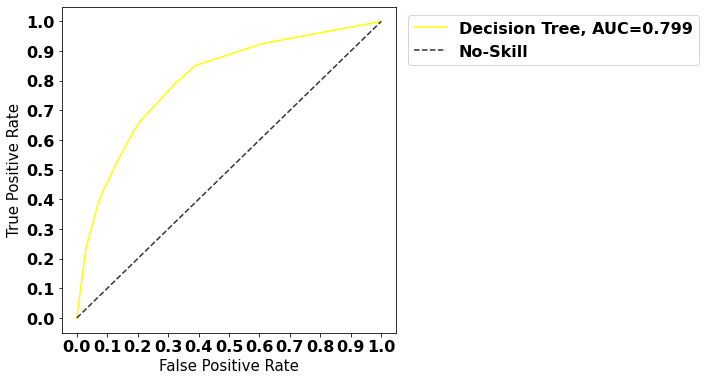

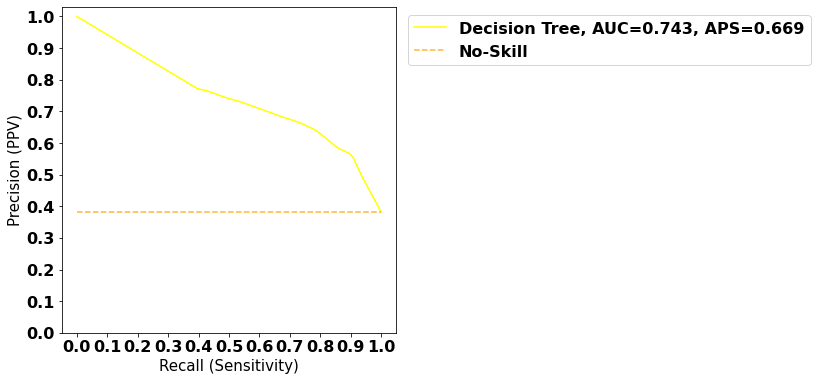

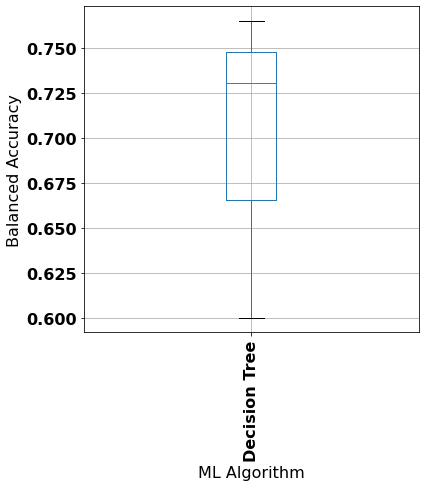

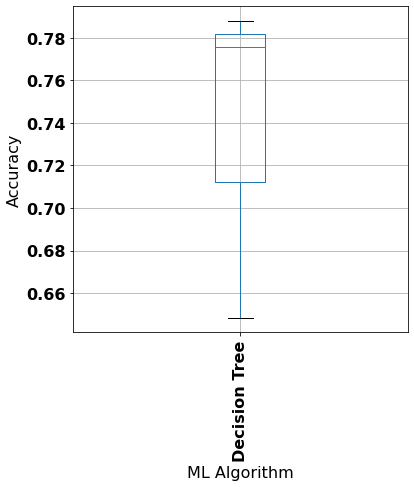

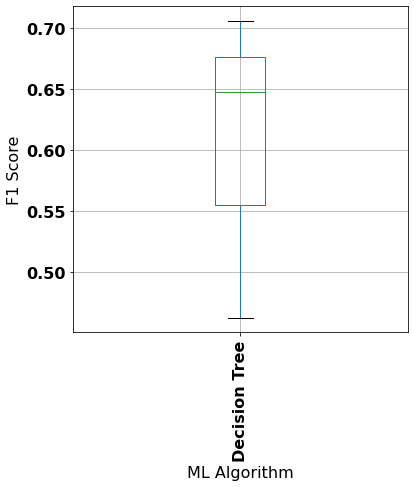

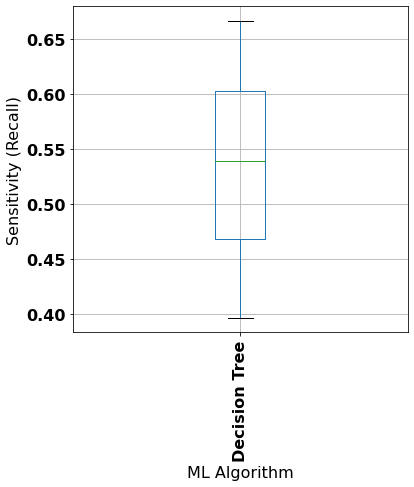

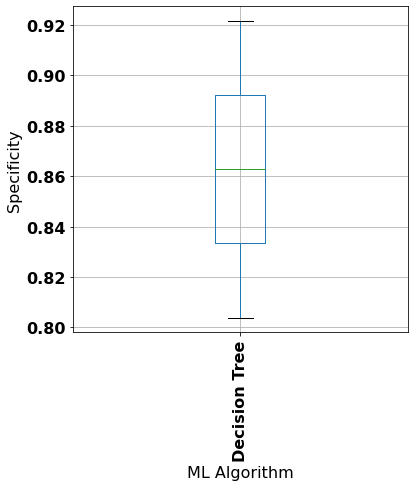

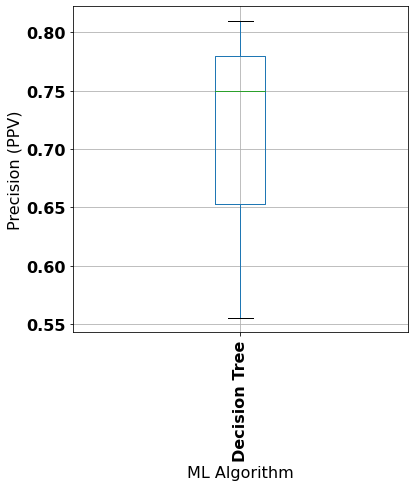

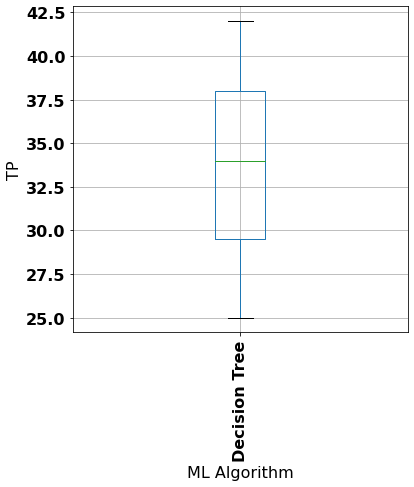

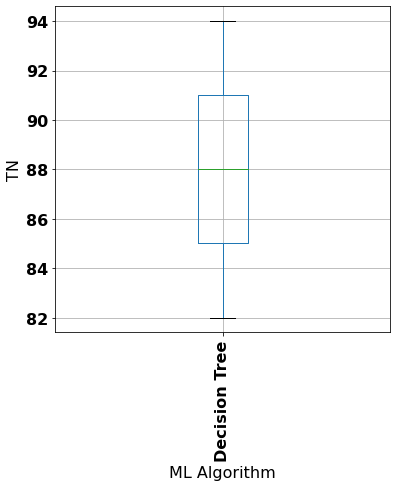

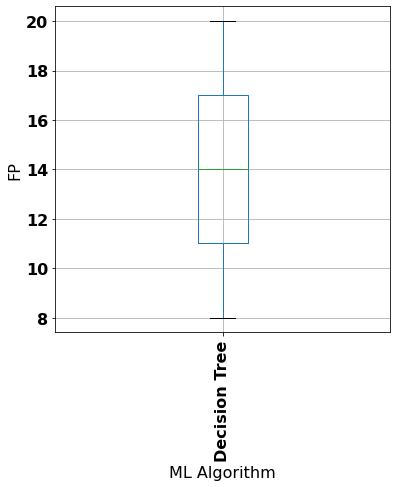

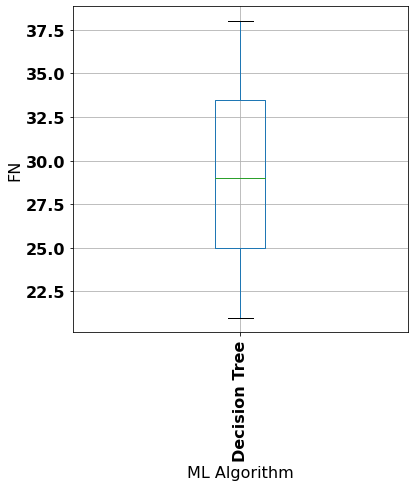

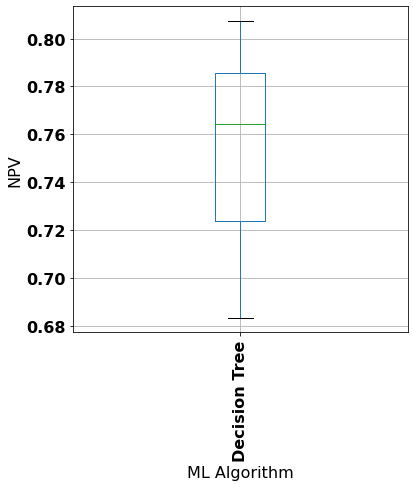

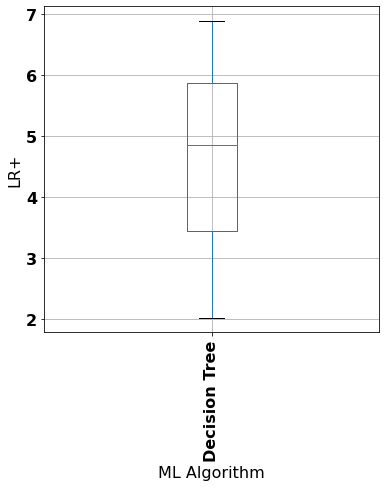

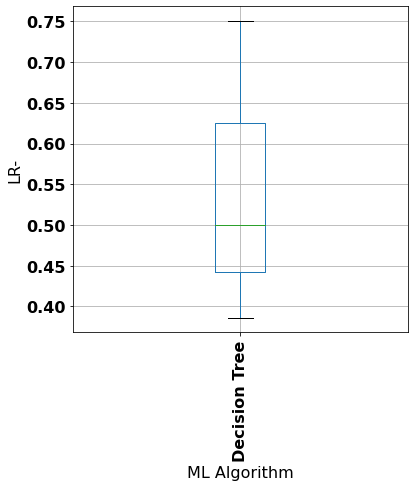

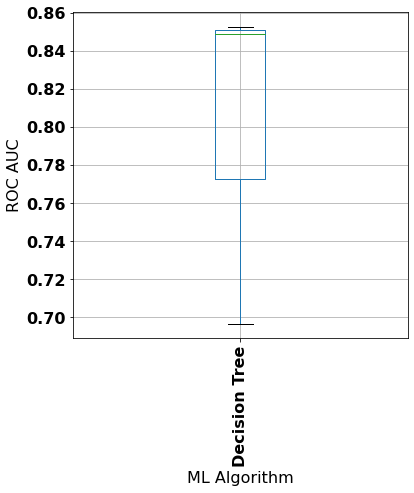

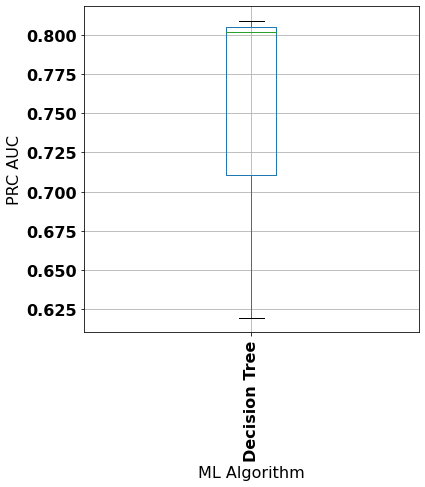

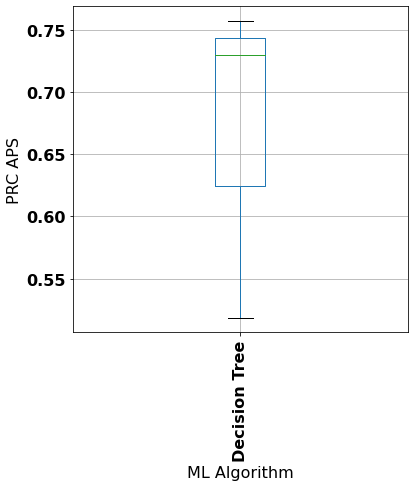

hcc-data_example_rep phase 9 complete


In [34]:
if applyToReplication:
    data_name = data_path_for_rep.split('/')[-1].split('.')[0] #Save unique dataset names so that analysis is run only once if there is both a .txt and .csv version of dataset with same name.
    full_path = output_path + "/" + experiment_name + "/" + data_name #location of folder containing models respective training dataset

    if not os.path.exists(full_path+"/applymodel"):
        os.mkdir(full_path+"/applymodel")

    #Determine file extension of datasets in target folder:
    file_count = 0
    unique_datanames = []
    for datasetFilename in glob.glob(rep_data_path+'/*'):
        datasetFilename = str(datasetFilename).replace('\\','/')

        file_extension = datasetFilename.split('/')[-1].split('.')[-1]
        apply_name = datasetFilename.split('/')[-1].split('.')[0] #Save unique dataset names so that analysis is run only once if there is both a .txt and .csv version of dataset with same name.
        if not os.path.exists(full_path+"/applymodel/"+apply_name):
            os.mkdir(full_path+"/applymodel/"+apply_name)

        if file_extension == 'txt' or file_extension == 'csv':
            if apply_name not in unique_datanames:
                unique_datanames.append(apply_name)
                ApplyModelJob.job(datasetFilename,full_path,class_label,instance_label,categorical_cutoff,sig_cutoff,cv_partitions,scale_data,impute_data,primary_metric,data_path_for_rep,match_label,plot_ROC,plot_PRC,plot_metric_boxplots,export_feature_correlations,jupyterRun,multi_impute)
                file_count += 1

    if file_count == 0: #Check that there was at least 1 dataset
        raise Exception("There must be at least one .txt or .csv dataset in rep_data_path directory")

## -----------------------------------------------------------------------------------------------------------------
## Phase 10: PDF Apply Report Generator (Optional)

In [35]:
import PDF_ReportJob

In [36]:
if applyToReplication:
    experiment_path = output_path+'/'+experiment_name
    PDF_ReportJob.job(experiment_path,'False',rep_data_path,data_path_for_rep)

2022-05-18 17:25:06.069983
Starting Report
Publishing Model Prediction Summary
Publishing Average Model Prediction Statistics
Phase 10 complete


## -----------------------------------------------------------------------------------------------------------------
## Phase 11: File Cleanup (Optional)

In [37]:
import shutil

In [38]:
# Get dataset paths for all completed dataset analyses in experiment folder
datasets = os.listdir(experiment_path)
experiment_name = experiment_path.split('/')[-1] #Name of experiment folder
removeList = removeList = ['metadata.pickle','metadata.csv','algInfo.pickle','jobsCompleted','logs','jobs','DatasetComparisons','UsefulNotebooks',experiment_name+'_ML_Pipeline_Report.pdf']
for text in removeList:
    if text in datasets:
        datasets.remove(text)

#Delete jobscompleted folder/files
try:
    shutil.rmtree(experiment_path+'/'+'jobsCompleted')
except:
    pass

#Delete target files within each dataset subfolder
for dataset in datasets:
    #Delete individual runtime files (save runtime summary generated in phase 6)
    if eval(del_time):
        try:
            shutil.rmtree(experiment_path+'/'+dataset+'/'+'runtime')
            print("Individual Runtime Files Deleted")
        except:
            pass
    #Delete temporary feature importance pickle files (only needed for phase 4 and then saved as summary files in phase 6)
    try:
        shutil.rmtree(experiment_path+'/'+dataset+'/feature_selection/mutualinformation/pickledForPhase4')
        print("Mutual Information Pickle Files Deleted")
    except:
        pass
    try:
        shutil.rmtree(experiment_path+'/'+dataset+'/feature_selection/multisurf/pickledForPhase4')
        print("MultiSURF Pickle Files Deleted")
    except:
        pass
    #Delete older training and testing CV datasets (does not delete any final versions used for training). Older cv datasets might have been kept to see what they look like prior to preprocessing and feature selection.
    if eval(del_oldCV):
        #Delete CV files generated after preprocessing but before feature selection
        files = glob.glob(experiment_path+'/'+dataset+'/CVDatasets/*CVOnly*')
        for f in files:
            try:
                os.remove(f)
                print("Deleted Intermediary CV-Only Dataset Files")
            except:
                pass
        #Delete CV files generated after CV partitioning but before preprocessing
        files = glob.glob(experiment_path+'/'+dataset+'/CVDatasets/*CVPre*')
        for f in files:
            try:
                os.remove(f)
                print("Deleted Intermediary CV-Pre Dataset Files")
            except:
                pass

Individual Runtime Files Deleted
Mutual Information Pickle Files Deleted
MultiSURF Pickle Files Deleted
Individual Runtime Files Deleted
Mutual Information Pickle Files Deleted
MultiSURF Pickle Files Deleted
